In [3]:
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.svm import SVC

import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D


# create a custom colourmap for use throughout
colors = ["#5e8fb4", "#FFFFFF", "#e6b4b0"]
n_bins = 500  # Discretizes the interpolation into bins
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

# Function for creating heatmaps with easier editing

### This code was retrieved from an online repository, found at https://github.com/DTrimarchi10/confusion_matrix

In [4]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.4f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Section 1 - data processing

### Importing and dropping

In [5]:
#import each of the datasets 
dfa = pd.read_csv('./thorax_and_wing_traits.csv')
dfb = pd.read_csv('./wing_asymmetry.csv')
dfc = pd.read_csv('./wing_traits_and_asymmetry.csv')

#create list of dataframes to view all iteratively
dfs_original = [dfa, dfb, dfc]

#view each dataframe
for df in dfs_original:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731 entries, 0 to 1730
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Species        1731 non-null   object 
 1   Population     1731 non-null   object 
 2   Latitude       1731 non-null   float64
 3   Longitude      1731 non-null   float64
 4   Year_start     1731 non-null   int64  
 5   Year_end       1731 non-null   int64  
 6   Temperature    1731 non-null   int64  
 7   Vial           1731 non-null   int64  
 8   Replicate      1731 non-null   int64  
 9   Sex            1731 non-null   object 
 10  Thorax_length  1731 non-null   object 
 11  l2             1731 non-null   float64
 12  l3p            1731 non-null   float64
 13  l3d            1731 non-null   float64
 14  lpd            1731 non-null   float64
 15  l3             1731 non-null   float64
 16  w1             1731 non-null   float64
 17  w2             1731 non-null   float64
 18  w3      

In [6]:
# import the combined data - see combining_data.ipynb for how this was created
# also order the data
original_df = pd.read_csv('all_data.csv')
column_order = ['Fly_ID', 'Species', 'Population', 'Latitude','Longitude', 'Year_start','Year_end', 'Temperature','Vial','Replicate', 'Sex', 'Thorax_length', 'l2', 'l3p', 'l3d','lpd', 'l3', 'w1', 'w2', 'w3', 'wing_loading', 'Wing_area', 'Wing_shape', 'Wing_vein', 'Asymmetry_l2', 'Asymmetry_l3p', 'Asymmetry_l3d', 'Asymmetry_lpd', 'Asymmetry_l3', 'Asymmetry_w1', 'Asymmetry_w2', 'Asymmetry_w3', 'Asymmetry_wing_area', 'Asymmetry_wing_shape', 'Asymmetry_wing_vein']
df = original_df[column_order]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731 entries, 0 to 1730
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Fly_ID                1731 non-null   int64  
 1   Species               1731 non-null   object 
 2   Population            1731 non-null   object 
 3   Latitude              1731 non-null   float64
 4   Longitude             1731 non-null   float64
 5   Year_start            1731 non-null   int64  
 6   Year_end              1731 non-null   int64  
 7   Temperature           1731 non-null   int64  
 8   Vial                  1731 non-null   int64  
 9   Replicate             1731 non-null   int64  
 10  Sex                   1731 non-null   object 
 11  Thorax_length         1731 non-null   object 
 12  l2                    1731 non-null   float64
 13  l3p                   1731 non-null   float64
 14  l3d                   1731 non-null   float64
 15  lpd                  

In [46]:
original_df

Fly_ID     Species Population  Latitude  Longitude  Year_start  \
0          1  D.aldrichi    Binjour    -25.52     151.45        1994   
1          2  D.aldrichi    Binjour    -25.52     151.45        1994   
2          3  D.aldrichi    Binjour    -25.52     151.45        1994   
3          4  D.aldrichi    Binjour    -25.52     151.45        1994   
4          5  D.aldrichi    Binjour    -25.52     151.45        1994   
...      ...         ...        ...       ...        ...         ...   
1726    1727  D.buzzatii    Wahruna    -25.20     151.17        1994   
1727    1728  D.buzzatii    Wahruna    -25.20     151.17        1994   
1728    1729  D.buzzatii    Wahruna    -25.20     151.17        1994   
1729    1730  D.buzzatii    Wahruna    -25.20     151.17        1994   
1730    1731  D.buzzatii    Wahruna    -25.20     151.17        1994   

      Year_end  Temperature  Vial  Replicate  ... Asymmetry_l3 Asymmetry_w1  \
0         1994           20     1          1  ...        0.047        0.016   
1         1994           20     1          1  ...        0.015        0.001   
2         1994           20     1          2  ...        0.013        0.028   
3         1994           20     1          2  ...        0.020        0.006   
4         1994           20     2          1  ...        0.005        0.000   
...        ...          ...   ...        ...  ...          ...          ...   
1726      1994           30    10          1  ...        0.003        0.018   
1727      1994           30    10          2  ...        0.011        0.016   
1728      1994           30    10          2  ...        0.006        0.007   
1729      1994           30    10          3  ...        0.045        0.005   
1730      1994           30    10          3  ...        0.008        0.020   

      Asymmetry_w2  Asymmetry_w3  Wing_area  Wing_shape  Wing_vein  \
0            0.031         0.031      1.223       2.296      2.597   
1            0.004         0.004      1.006       2.289      2.528   
2            0.011         0.047      1.149       2.340      2.580   
3            0.002         0.011      1.000       2.180      2.508   
4            0.027         0.011      1.160       2.275      2.589   
...            ...           ...        ...         ...        ...   
1726         0.007         0.003      0.719       2.346      2.479   
1727         0.038         0.029      0.866       2.305      2.584   
1728         0.007         0.009      0.741       2.197      2.607   
1729         0.017         0.014      0.840       2.254      2.582   
1730         0.006         0.021      0.804       2.251      2.439   

      Asymmetry_wing_area  Asymmetry_wing_shape  Asymmetry_wing_vein  
0                   0.043                 0.010                0.028  
1                   0.006                 0.018                0.044  
2                   0.039                 0.053                0.140  
3                   0.016                 0.007                0.074  
4                   0.003                 0.005                0.100  
...                   ...                   ...                  ...  
1726                0.015                 0.058                0.021  
1727                0.011                 0.055                0.099  
1728                0.009                 0.011                0.134  
1729                0.015                 0.065                0.008  
1730                0.022                 0.044                0.039  

[1731 rows x 35 columns]

In [7]:
# '.' values in the data - need to replace with NaN
df['wing_loading'] = df['wing_loading'].replace('.', np.nan)
df['Thorax_length'] = df['Thorax_length'].replace('.', np.nan)

# then convert to float
df['wing_loading'] = df['wing_loading'].astype(float)
df['Thorax_length'] = df['Thorax_length'].astype(float)

# we have some 0 values - assuming these are missing data as 0.000 
# not possible as a length
#find the columns they exist in
zero_mask = (df != 'NaN') & (df == 0.000)
zero_locations = zero_mask.any()
print(f"zero locations: {zero_locations[zero_locations]}\n")

# replace all zeroes with nan
df.replace(0.000, float('nan'), inplace=True)

zero locations: l2                      True
l3p                     True
l3d                     True
lpd                     True
l3                      True
w1                      True
w2                      True
w3                      True
wing_loading            True
Wing_area               True
Asymmetry_l2            True
Asymmetry_l3p           True
Asymmetry_l3d           True
Asymmetry_lpd           True
Asymmetry_l3            True
Asymmetry_w1            True
Asymmetry_w2            True
Asymmetry_w3            True
Asymmetry_wing_area     True
Asymmetry_wing_shape    True
Asymmetry_wing_vein     True
dtype: bool



In [8]:
# drop columns not needed
df = df.drop(columns =['Fly_ID', 'Latitude', 'Longitude', "Year_start", 
                                'Year_end', 'Vial', 'Replicate'])

In [9]:
# encode the features numerically

label_encoder = preprocessing.LabelEncoder()
df.Population = label_encoder.fit_transform(df.Population)
df.Species = label_encoder.fit_transform(df.Species)
df.Sex = label_encoder.fit_transform(df.Sex)

### Creating heatmap

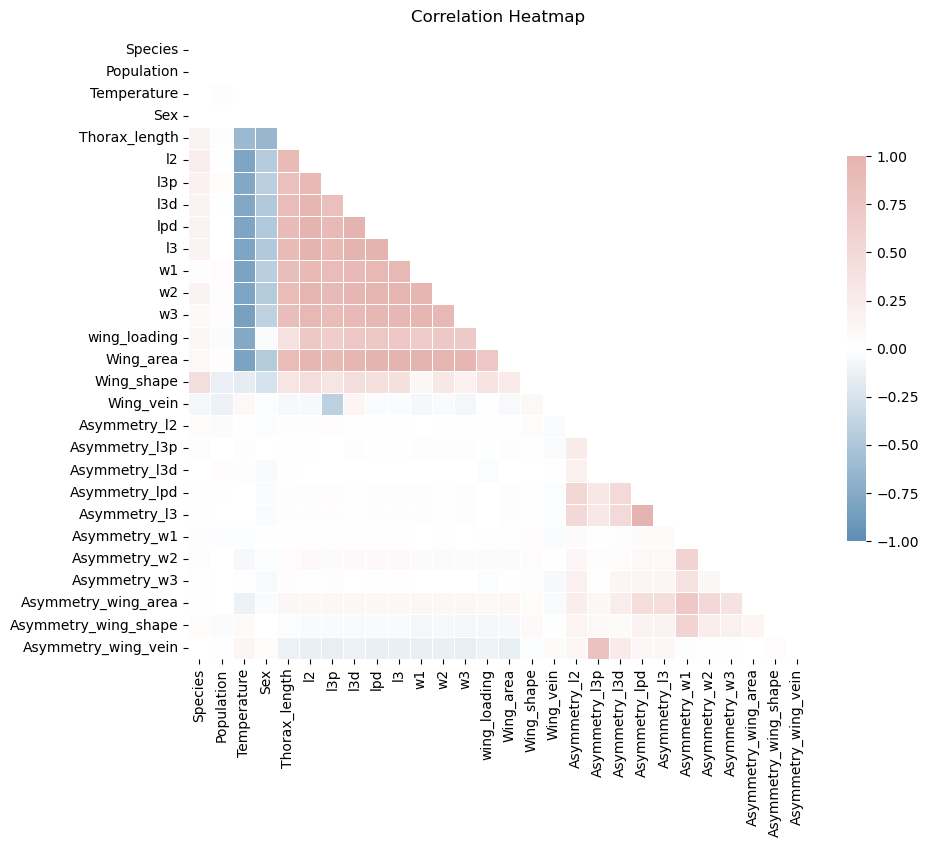

In [10]:
# Generate the correlation matrices
corr = df.corr()

# Generate masks for the upper triangles
mask1 = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,10))
# More features
sns.heatmap(corr, mask=mask1, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            vmax=1, vmin=-1)
plt.title("Correlation Heatmap", fontdict={'fontsize': 12}, pad=12)
plt.show()

### Splitting data into subsets

In [11]:
#create a version of the dataframe which just has no observations with null data at all
df_nonulls = df.dropna()

#dataframe with all features, but no null data
df_features = df_nonulls
# shuffle the data
df_features = df_features.sample(frac=1, random_state=10)

#dataframe without asymmetry features, but no null data
df_neither = df_features.drop(columns = ['Asymmetry_l2', 'Asymmetry_l3p', 'Asymmetry_l3d', 
                                         'Asymmetry_lpd', 'Asymmetry_l3', 'Asymmetry_w1', 
                                         'Asymmetry_w2', 'Asymmetry_w3', 'Asymmetry_wing_area', 
                                         'Asymmetry_wing_shape', 'Asymmetry_wing_vein'])
# shuffle the data
df_neither = df_neither.sample(frac=1, random_state=10)



#dataframe with no asymmetry features, but imputed null data
df_obs = df.drop(columns=['Asymmetry_l2', 'Asymmetry_l3p', 'Asymmetry_l3d', 'Asymmetry_lpd', 
                          'Asymmetry_l3', 'Asymmetry_w1', 'Asymmetry_w2', 'Asymmetry_w3', 
                          'Asymmetry_wing_area', 'Asymmetry_wing_shape', 'Asymmetry_wing_vein'])
#impute the null data
imputer = sklearn.impute.SimpleImputer(strategy='mean')
df_obs = pd.DataFrame(imputer.fit_transform(df_obs), columns=df_obs.columns)
# shuffle the data
df_obs = df_obs.sample(frac=1, random_state=10)

### Train-test split and normalise

In [12]:
# train test split 70/30 on all other data for temperature, for each dataframe
# this combines the x input features into one dataframe and the y label output into another dataframe

x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(
    df_features[['Species', 'Population', 'Sex', 'Thorax_length', 'l2', 'l3p', 'l3d','lpd', 'l3', 'w1', 'w2', 'w3', 
            'wing_loading', 'Wing_area', 'Wing_shape', 'Wing_vein', 'Asymmetry_l2', 'Asymmetry_l3p', 'Asymmetry_l3d', 
            'Asymmetry_lpd', 'Asymmetry_l3', 'Asymmetry_w1', 'Asymmetry_w2', 'Asymmetry_w3', 'Asymmetry_wing_area', 
            'Asymmetry_wing_shape', 'Asymmetry_wing_vein']], 
            df_features['Temperature'], test_size=0.3, random_state=42)


x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(
    df_obs[['Species', 'Population', 'Sex', 'Thorax_length', 'l2', 'l3p', 'l3d','lpd', 'l3', 'w1', 'w2', 'w3', 
            'wing_loading', 'Wing_area', 'Wing_shape', 'Wing_vein']], 
            df_obs['Temperature'], test_size=0.3, random_state=42)


x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(
    df_neither[['Species', 'Population', 'Sex', 'Thorax_length', 'l2', 'l3p', 'l3d','lpd', 'l3', 'w1', 'w2', 'w3', 
            'wing_loading', 'Wing_area', 'Wing_shape', 'Wing_vein']], 
            df_neither['Temperature'], test_size=0.3, random_state=42)


In [13]:
# normalising
# Original data
original_x = [x_train_f, x_test_f, x_train_o, x_test_o, x_train_n, x_test_n]

# Initialize scaler
scaler = StandardScaler()

# Normalized data lists
normalised_x = []

# Normalize each dataset
for x_data in original_x:
    normalised_x.append(scaler.fit_transform(x_data))

# Unpack the normalized data back into individual variables
x_train_f_norm, x_test_f_norm, x_train_o_norm, x_test_o_norm, x_train_n_norm, x_test_n_norm = normalised_x

In [14]:
print(x_train_f_norm)

[[ 0.93207379  0.00629952 -0.99506657 ... -1.20578128 -0.1886337
   0.57596923]
 [ 0.93207379 -0.70134645 -0.99506657 ... -1.08121099 -0.77257595
  -0.30210957]
 [-1.07287643  0.71394549  1.00495789 ... -0.33378924 -0.42908051
   0.11382249]
 ...
 [-1.07287643  1.42159145  1.00495789 ... -1.08121099 -0.25733279
  -0.68723185]
 [ 0.93207379 -0.70134645 -0.99506657 ...  2.40675718 -0.25733279
  -0.85668566]
 [-1.07287643  1.42159145 -0.99506657 ...  2.65589776 -0.70387686
   0.4527301 ]]


# Section 2 - KNN

## Train the model and cross validate

In [15]:
# Define the range of k values to test
k_values = [i for i in range(1, 1000)]

In [16]:
# train the model on each data subset, record accuracy scores
knn_acc_f = {}
knn_acc_test_f = {}
knn_acc_o = {}
knn_acc_test_o = {}
knn_acc_n = {}
knn_acc_test_n = {}



# train the model on each data subset, record accuracy scores
for k in k_values:

    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Step 1: Normalize the data
        ('knn', KNeighborsClassifier(n_neighbors=k))  # Step 2: kNN classifier
    ])

    # Perform cross-validation
    knn_scores_f = cross_val_score(pipeline, x_train_f, y_train_f, scoring='accuracy')
    knn_acc_f[k] = np.mean(knn_scores_f)
    pipeline.fit(x_train_f, y_train_f)
    knn_y_pred_f = pipeline.predict(x_test_f)
    try:
        knn_acc_test_f[k] = accuracy_score(y_test_f, knn_y_pred_f)
    except:
        continue

    knn_scores_o = cross_val_score(pipeline, x_train_o, y_train_o, scoring='accuracy')
    knn_acc_o[k] = np.mean(knn_scores_o)
    pipeline.fit(x_train_o, y_train_o)
    knn_y_pred_o = pipeline.predict(x_test_o)
    try:
        knn_acc_test_o[k] = accuracy_score(y_test_o, knn_y_pred_o)
    except:
        continue

    knn_scores_n = cross_val_score(pipeline, x_train_n, y_train_n, scoring='accuracy')
    knn_acc_n[k] = np.mean(knn_scores_n)
    pipeline.fit(x_train_n, y_train_n)
    knn_y_pred_n = pipeline.predict(x_test_n)
    try:
        knn_acc_test_n[k] = accuracy_score(y_test_n, knn_y_pred_n)
    except:
        continue





c:\Users\Georgia\Documents\COMP4702\COMP7703\Assignment\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Georgia\Documents\COMP4702\COMP7703\Assignment\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\Georgia\Documents\COMP4702\COMP7703\Assignment\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\Georgia\Documents\COMP4702\COMP7703\Assignment\.conda\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Georgia\Documents\COMP4702\COMP7703\Assignment\.conda\Lib\site-packages\sklearn\utils\_response.

In [17]:
# print the results for my own information
# and record the best k value for each subset

print(f"Max train accuracy for 'More Features': {max(knn_acc_f.values())}")
knn_max_f = max(knn_acc_f, key=knn_acc_f.get)
print('k:', knn_max_f)
print(f"Test accuracy at k={knn_max_f}: {knn_acc_test_f[knn_max_f]}")
print(f"Max test accuracy for 'More Features': {max(knn_acc_test_f.values())} at k={max(knn_acc_test_f, key=knn_acc_test_f.get)}")
print()

print(f"Max train accuracy for 'More Observations': {max(knn_acc_o.values())}")
knn_max_o = max(knn_acc_o, key=knn_acc_o.get)
print('k:', knn_max_o)
print(f"Test accuracy at k={knn_max_o}: {knn_acc_test_o[knn_max_o]}")
print(f"Max test accuracy for 'More Observations': {max(knn_acc_test_o.values())} at k={max(knn_acc_test_o, key=knn_acc_test_o.get)}")
print()

print(f"Max train accuracy for 'Neither': {max(knn_acc_n.values())}")
knn_max_n = max(knn_acc_n, key=knn_acc_n.get)
print('k:', knn_max_n)
print(f"Test accuracy at k={knn_max_n}: {knn_acc_test_n[knn_max_n]}")
print(f"Max test accuracy for 'Neither': {max(knn_acc_test_n.values())} at k={max(knn_acc_test_n, key=knn_acc_test_n.get)}")
print()

Max train accuracy for 'More Features': 0.8931766083012243
k: 25
Test accuracy at k=25: 0.8963133640552995
Max test accuracy for 'More Features': 0.923963133640553 at k=22

Max train accuracy for 'More Observations': 0.9471550522055573
k: 9
Test accuracy at k=9: 0.9307692307692308
Max test accuracy for 'More Observations': 0.9442307692307692 at k=11

Max train accuracy for 'Neither': 0.9386382480612593
k: 23
Test accuracy at k=23: 0.9470046082949308
Max test accuracy for 'Neither': 0.9516129032258065 at k=8



## Plot the accuracy against k

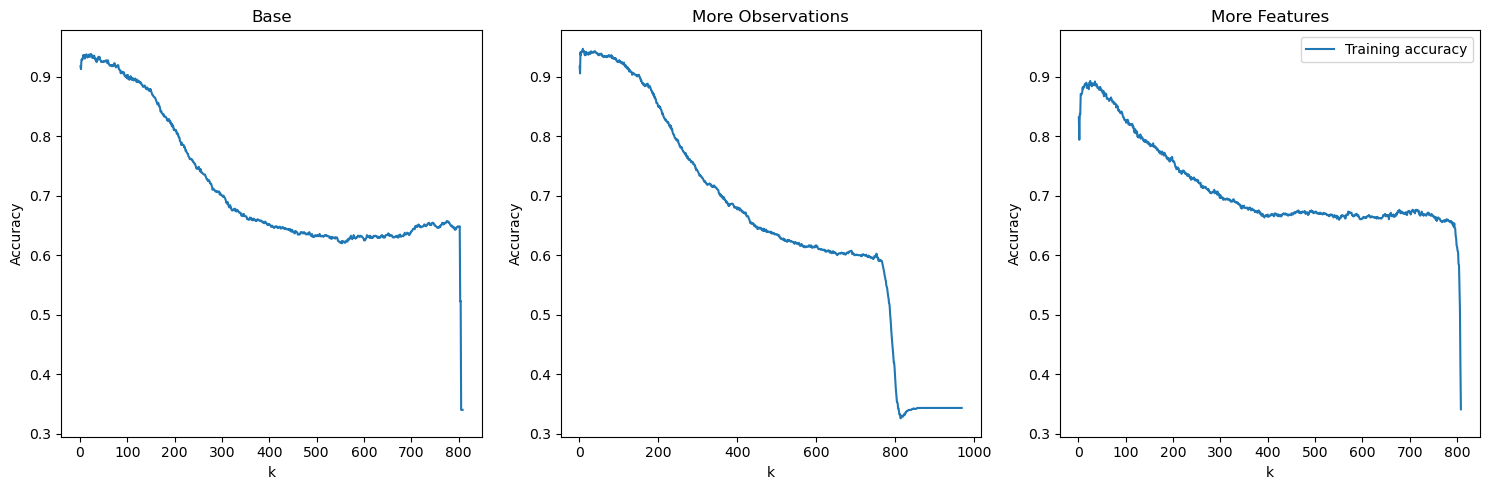

In [18]:
# Plot the accuracy scores for each k value
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axes[2].plot(k_values, knn_acc_f.values(), label='Training accuracy')
axes[2].set_title("More Features")
axes[2].set_xlabel("k")
axes[2].set_ylabel("Accuracy")
# axes[0].set_xticks(k_values)
# axes[0].set_xscale('log', base=2)
axes[2].tick_params(axis='y', which='both', labelleft=True)  # Ensure y-axis labels are shown
axes[2].legend()


axes[1].plot(k_values, knn_acc_o.values())
axes[1].set_title("More Observations")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Accuracy")
# axes[1].set_xticks(k_values)
# axes[1].set_xscale('log', base=2)
axes[1].tick_params(axis='y', which='both', labelleft=True)  


axes[0].plot(k_values, knn_acc_n.values())
axes[0].set_title("Base")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Accuracy")
# axes[2].set_xticks(k_values)
# axes[2].set_xscale('log', base=2)
axes[0].tick_params(axis='y', which='both', labelleft=True)

plt.legend()
plt.tight_layout()
plt.show()

## Plot the test accuracy

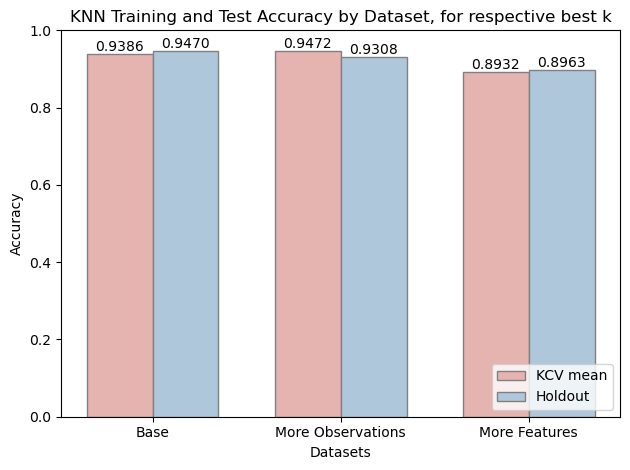

In [19]:
# plot accuracy bargraph
datasets = ['Base', 'More Observations', 'More Features']
accuracies = ['KCV mean', 'Holdout']
scores = np.array([
    [knn_acc_n[knn_max_n], knn_acc_test_n[knn_max_n]],
    [knn_acc_o[knn_max_o], knn_acc_test_o[knn_max_o]],  
    [knn_acc_f[knn_max_f], knn_acc_test_f[knn_max_f]]
       
])

# Set width of bar
bar_width = 0.35

# Set positions of bars on x-axis
r1 = np.arange(3)
r2 = [x + bar_width for x in r1]

# Create grouped bar plot
bars1 = plt.bar(r1, scores[:, 0], color=cmap(1.0), width=bar_width, edgecolor='grey', label=accuracies[0])
bars2 = plt.bar(r2, scores[:, 1], color=cmap(0.25), width=bar_width, edgecolor='grey', label=accuracies[1])

# Add labels to bars
# note - GPT 3.5 was used to help with this function
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 '%.4f' % height,
                 ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

# Add labels, title, and legend
plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.title('KNN Training and Test Accuracy by Dataset, for respective best k')
plt.xticks([r + bar_width/2 for r in range(3)], datasets)
plt.ylim(0, 1)
plt.legend()

# Show plot
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()

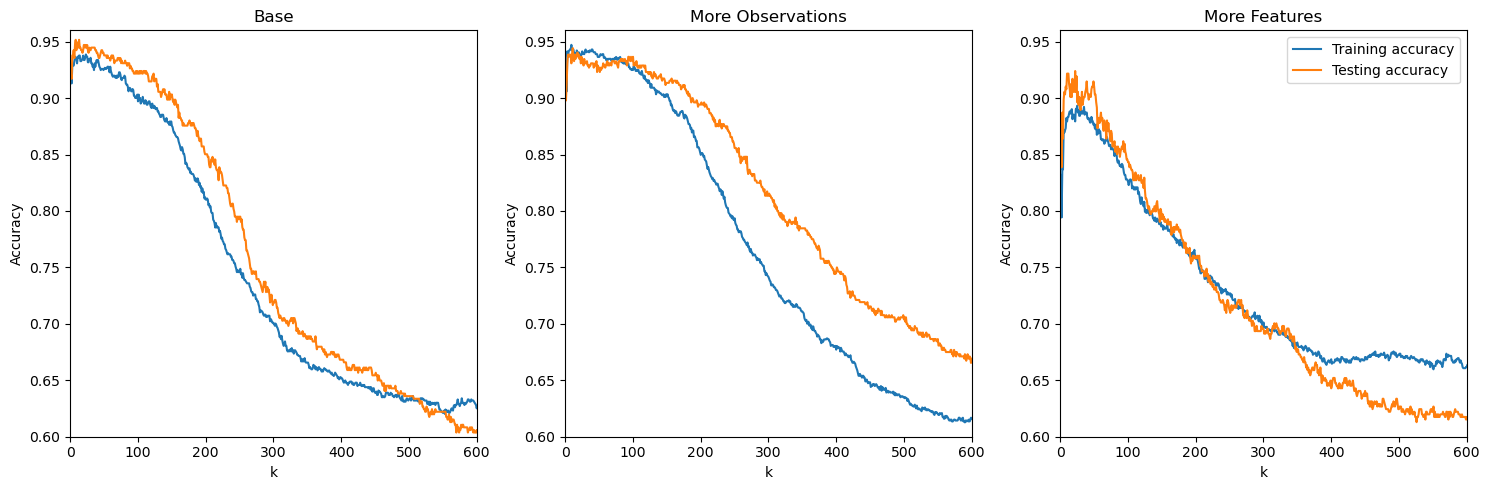

In [20]:
# Plot the accuracy scores for each k value
# WITH TEST ACCURACY, SMALLER SUBSET OF K VALUES
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)


axes[2].plot(k_values, knn_acc_f.values(), label='Training accuracy')
axes[2].plot(k_values, knn_acc_test_f.values(), label='Testing accuracy')
axes[2].set_title("More Features")
axes[2].set_xlabel("k")
axes[2].set_ylabel("Accuracy")
axes[2].set_xlim(0, 600)
axes[2].set_ylim(0.6, 0.96)
axes[2].tick_params(axis='y', which='both', labelleft=True)  # Ensure y-axis labels are shown
axes[2].legend()


axes[1].plot(k_values, knn_acc_o.values(), label='Training accuracy')
axes[1].plot(k_values, knn_acc_test_o.values(), label='Testing accuracy')
axes[1].set_title("More Observations")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Accuracy")
axes[1].set_xlim(0, 600)
axes[1].tick_params(axis='y', which='both', labelleft=True)  


axes[0].plot(k_values, knn_acc_n.values(), label='Training accuracy')
axes[0].plot(k_values, knn_acc_test_n.values(), label='Testing accuracy')
axes[0].set_title("Base")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Accuracy")
axes[0].set_xlim(0, 600)
axes[0].tick_params(axis='y', which='both', labelleft=True)


plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

#### Version for plotting each graph individually

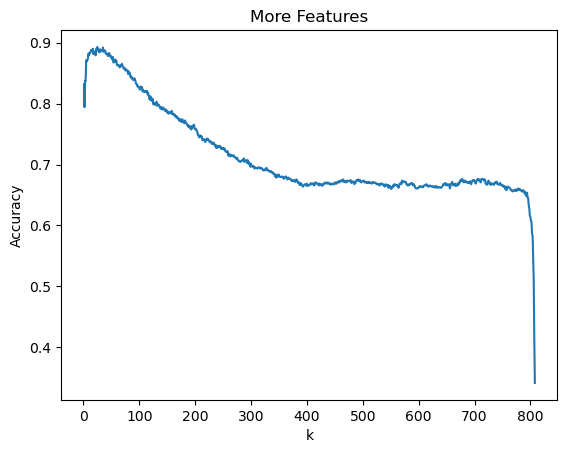

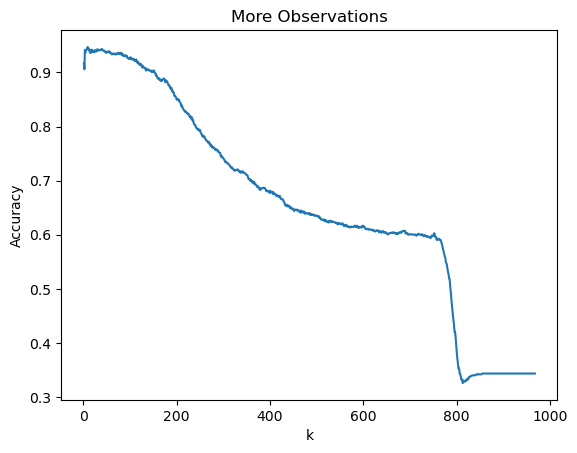

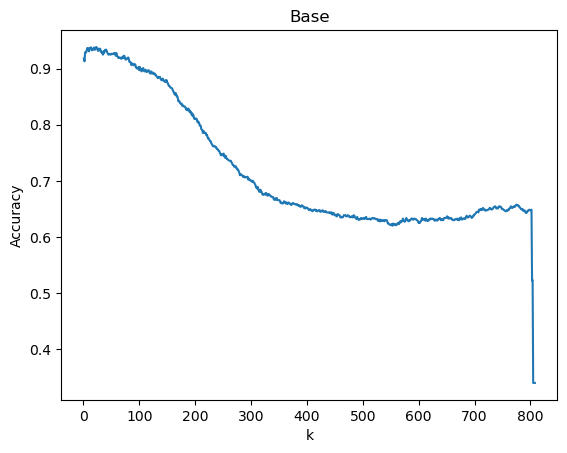

In [21]:
plt.plot(k_values, knn_acc_f.values(), label='More Features')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('More Features')
plt.show()

plt.plot(k_values, knn_acc_o.values(), label='More Observations')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('More Observations')
plt.show()

plt.plot(k_values, knn_acc_n.values(), label='Base')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Base')
plt.show()


## Train the model for best k

In [22]:
# This is needed for the confusion matrix

# define each pipeline
pipeline_f = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=knn_max_f)) 
])

pipeline_o = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=knn_max_o)) 
])

pipeline_n = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=knn_max_n)) 
])

# fit each pipeline to the training data
pipeline_f.fit(x_train_f, y_train_f)
pipeline_o.fit(x_train_o, y_train_o)
pipeline_n.fit(x_train_n, y_train_n)


# get predicted y values
knn_y_pred_f = pipeline_f.predict(x_test_f)
knn_y_pred_o = pipeline_o.predict(x_test_o)
knn_y_pred_n = pipeline_n.predict(x_test_n)

## Confusion matrices

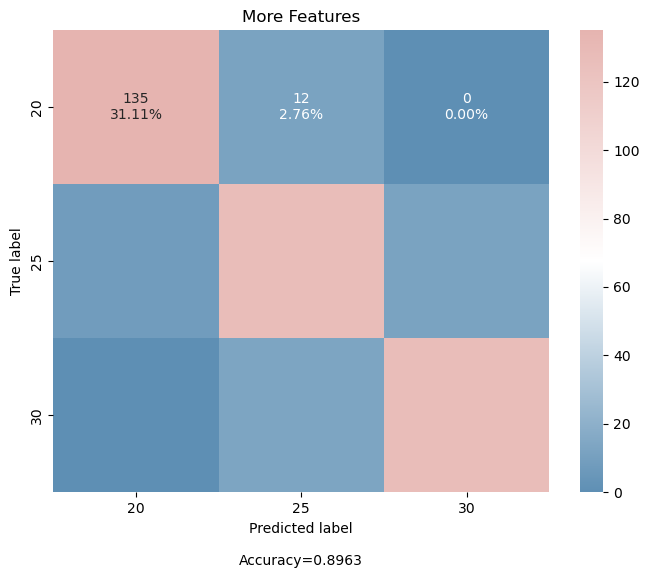

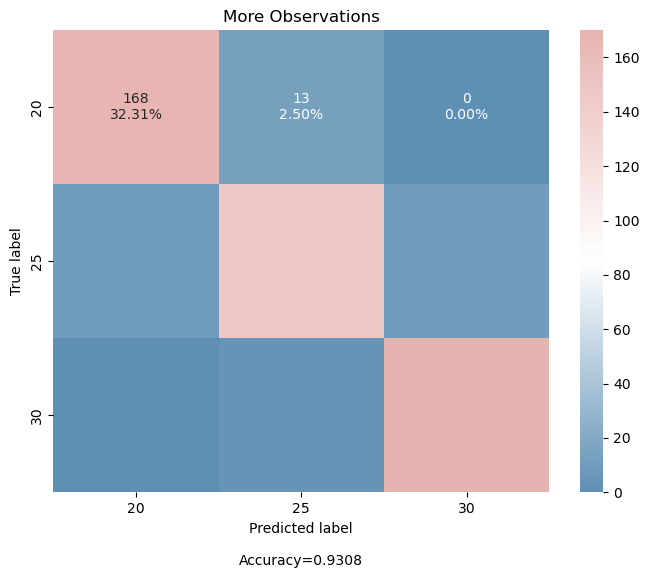

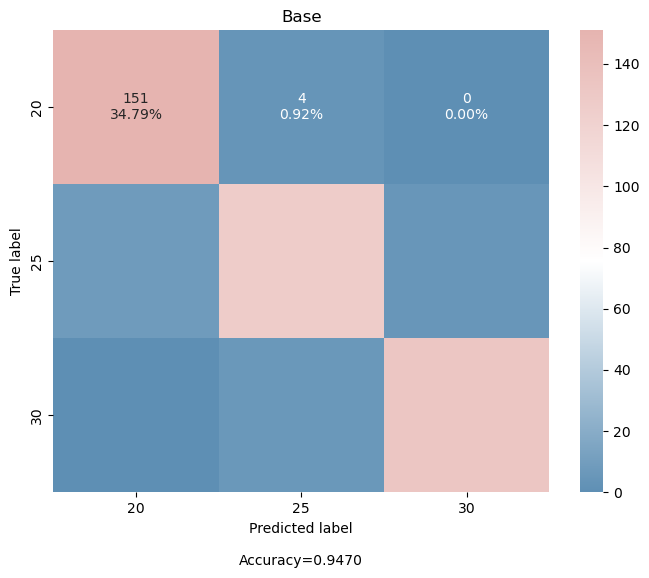

In [23]:
knn_confmat_f = confusion_matrix(y_test_f, knn_y_pred_f)
knn_confmat_o = confusion_matrix(y_test_o, knn_y_pred_o)
knn_confmat_n = confusion_matrix(y_test_n, knn_y_pred_n)

categories = [20, 25, 30]

f1 = make_confusion_matrix(knn_confmat_f, figsize=(8,6), categories=categories, title='More Features', cmap=cmap)
f2 = make_confusion_matrix(knn_confmat_o, figsize=(8,6), categories=categories, title='More Observations', cmap=cmap)
f3 = make_confusion_matrix(knn_confmat_n, figsize=(8,6), categories=categories, title='Base', cmap=cmap)


## ROC Curves

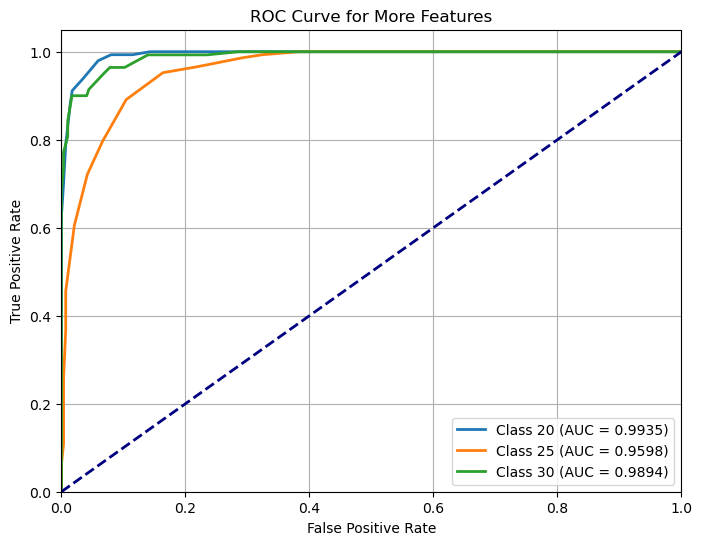

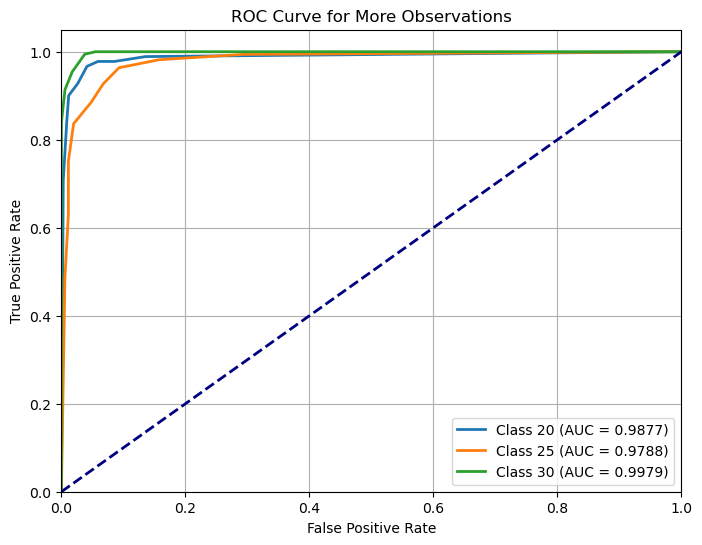

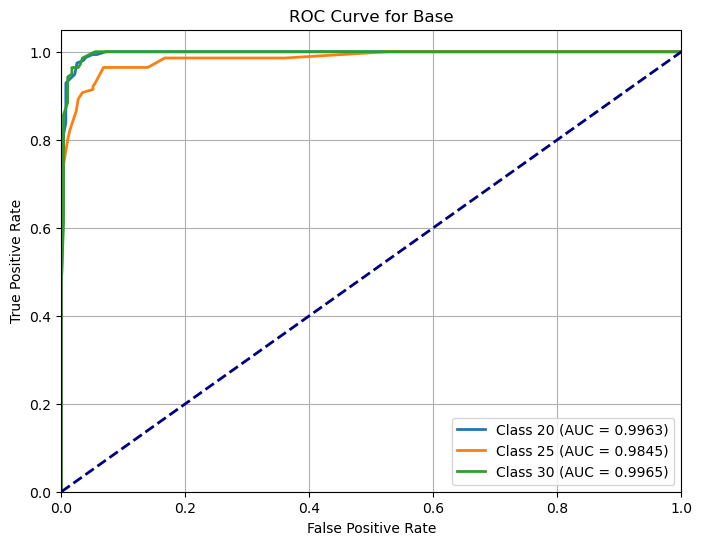

In [24]:

# GPT3.5 assited with modifying this code from the sklearn documentation 
# to apply to this situation in particular

classes = [20, 25, 30]
# Predict probabilities for each class using the test set
knn_y_score_f = pipeline_f.predict_proba(x_test_f)
knn_y_score_o = pipeline_o.predict_proba(x_test_o)
knn_y_score_n = pipeline_n.predict_proba(x_test_n)


# Binarize the labels for ROC curve computation
knn_y_test_bin_f = label_binarize(y_test_f, classes=classes)
knn_y_test_bin_o = label_binarize(y_test_o, classes=classes)
knn_y_test_bin_n = label_binarize(y_test_n, classes=classes)

# Initialize variables for ROC curve and ROC AUC score
knn_fpr_f = dict()
knn_tpr_f = dict()
knn_roc_auc_f = dict()

knn_fpr_o = dict()
knn_tpr_o = dict()
knn_roc_auc_o = dict()

knn_fpr_n = dict()
knn_tpr_n = dict()
knn_roc_auc_n = dict()


# Compute ROC curve and ROC AUC score for each class in f
for i in range(len(pipeline.classes_)):
    knn_fpr_f[i], knn_tpr_f[i], _ = roc_curve(knn_y_test_bin_f[:, i], knn_y_score_f[:, i])
    knn_roc_auc_f[i] = auc(knn_fpr_f[i], knn_tpr_f[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i in range(len(classes)):
    plt.plot(knn_fpr_f[i], knn_tpr_f[i], lw=2, label=f'Class {classes[i]} (AUC = {knn_roc_auc_f[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for More Features')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



# Compute ROC curve and ROC AUC score for each class in o
for i in range(len(pipeline.classes_)):
    knn_fpr_o[i], knn_tpr_o[i], _ = roc_curve(knn_y_test_bin_o[:, i], knn_y_score_o[:, i])
    knn_roc_auc_o[i] = auc(knn_fpr_o[i], knn_tpr_o[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i in range(len(classes)):
    plt.plot(knn_fpr_o[i], knn_tpr_o[i], lw=2, label=f'Class {classes[i]} (AUC = {knn_roc_auc_o[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for More Observations')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



# Compute ROC curve and ROC AUC score for each class in base
for i in range(len(pipeline.classes_)):
    knn_fpr_n[i], knn_tpr_n[i], _ = roc_curve(knn_y_test_bin_n[:, i], knn_y_score_n[:, i])
    knn_roc_auc_n[i] = auc(knn_fpr_n[i], knn_tpr_n[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i in range(len(classes)):
    plt.plot(knn_fpr_n[i], knn_tpr_n[i], lw=2, label=f'Class {classes[i]} (AUC = {knn_roc_auc_n[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Base')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Section 3 - Random Forest

In [25]:
# set up the parameters for each model
num_features_f = [i for i in range(1, 29)]
max_depths_f = [i for i in range(1, 29)]
num_features = [i for i in range(1, 18)]
max_depths = [i for i in range(1, 18)]

# set up dictionaries to store the results
rf_oob_f = {}
rf_acc_f = {}
rf_oob_o = {}
rf_acc_o = {}
rf_oob_n = {}
rf_acc_n = {}

In [26]:
for f in num_features:
    for d in max_depths:
        key = (f, d)
        rf = RandomForestClassifier(n_estimators=50, max_depth=d, max_features=f, 
                                    oob_score=True, random_state=10)
        rf2 = RandomForestClassifier(n_estimators=50, max_depth=d, max_features=f, 
                                    oob_score=False, random_state=10)
        rf.fit(x_train_o_norm, y_train_o)
        rf_oob_o[key] = rf.oob_score_
        rf2.fit(x_train_o_norm, y_train_o)
        rf_y_pred_o = rf2.predict(x_test_o_norm)
        # rf_acc_o[key] = rf2.score(x_test_o_norm, y_test_o)
        rf_acc_o[key] = accuracy_score(y_test_o, rf_y_pred_o)

        rf.fit(x_train_n_norm, y_train_n)
        rf_oob_n[key] = rf.oob_score_
        rf2.fit(x_train_n_norm, y_train_n)
        # rf_acc_n[key] = rf2.score(x_test_n_norm, y_test_n)
        rf_y_pred_n = rf2.predict(x_test_n_norm)
        rf_acc_n[key] = accuracy_score(y_test_n, rf_y_pred_n)



In [27]:

for f in num_features_f:
    for d in max_depths_f:
        key = (f, d)
        rf = RandomForestClassifier(n_estimators=50, max_depth=d, max_features=f, 
                                    oob_score=True, random_state=10)
        rf2 = RandomForestClassifier(n_estimators=50, max_depth=d, max_features=f, 
                                    oob_score=False, random_state=10)
        
        rf.fit(x_train_f_norm, y_train_f)
        rf_oob_f[key] = rf.oob_score_
        rf2.fit(x_train_f_norm, y_train_f)
        # rf_acc_f[key] = rf2.score(x_test_f_norm, y_test_f)
        rf_y_pred_f = rf2.predict(x_test_f_norm)
        rf_acc_f[key] = accuracy_score(y_test_f, rf_y_pred_f)


        

In [28]:
print(f"Max OOB for 'More Features': {max(rf_oob_f.values())}")
print('features, depth:', max(rf_oob_f, key=rf_oob_f.get))

print(f"Max OOB for 'More Observations': {max(rf_oob_o.values())}")
print('features, depth:', max(rf_oob_o, key=rf_oob_o.get))

print(f"Max OOB for 'Neither/base': {max(rf_oob_n.values())}")
print('features, depth:', max(rf_oob_n, key=rf_oob_n.get))

Max OOB for 'More Features': 0.9248269040553907
features, depth: (10, 9)
Max OOB for 'More Observations': 0.9322873658133773
features, depth: (4, 15)
Max OOB for 'Neither/base': 0.9228486646884273
features, depth: (6, 9)


In [29]:
print(f"Max acc for 'More Features': {max(rf_acc_f.values())}")
rf_best_f = max(rf_oob_f, key=rf_oob_f.get)
print('features, depth:', max(rf_acc_f, key=rf_acc_f.get))
print(f"Accuracy at best OOB: {rf_acc_f[max(rf_oob_f, key=rf_oob_f.get)]}")

print(f"Max acc for 'More Observations': {max(rf_acc_o.values())}")
rf_best_o = max(rf_oob_o, key=rf_oob_o.get)
print('features, depth:', max(rf_acc_o, key=rf_acc_o.get))
print(f"Accuracy at best OOB: {rf_acc_o[max(rf_oob_o, key=rf_oob_o.get)]}")

print(f"Max acc for 'Neither/base': {max(rf_acc_n.values())}")
rf_best_n = max(rf_oob_n, key=rf_oob_n.get)
print('features, depth:', max(rf_acc_n, key=rf_acc_n.get))
print(f"Accuracy at best OOB: {rf_acc_n[max(rf_oob_n, key=rf_oob_n.get)]}")




Max acc for 'More Features': 0.9400921658986175
features, depth: (10, 5)
Accuracy at best OOB: 0.9193548387096774
Max acc for 'More Observations': 0.9307692307692308
features, depth: (3, 10)
Accuracy at best OOB: 0.9153846153846154
Max acc for 'Neither/base': 0.9354838709677419
features, depth: (16, 6)
Accuracy at best OOB: 0.923963133640553


## Plotting OOB scores

0.6407927332782825
0.9322873658133773


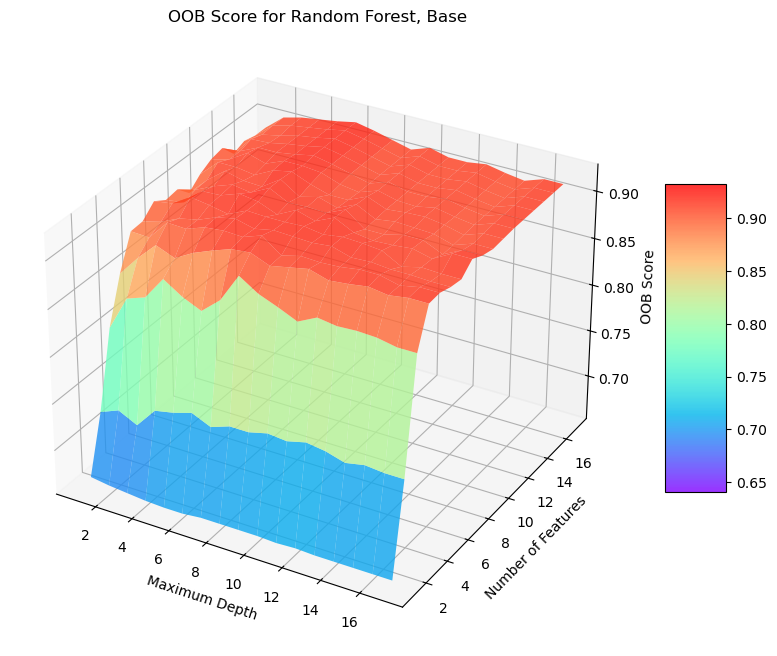

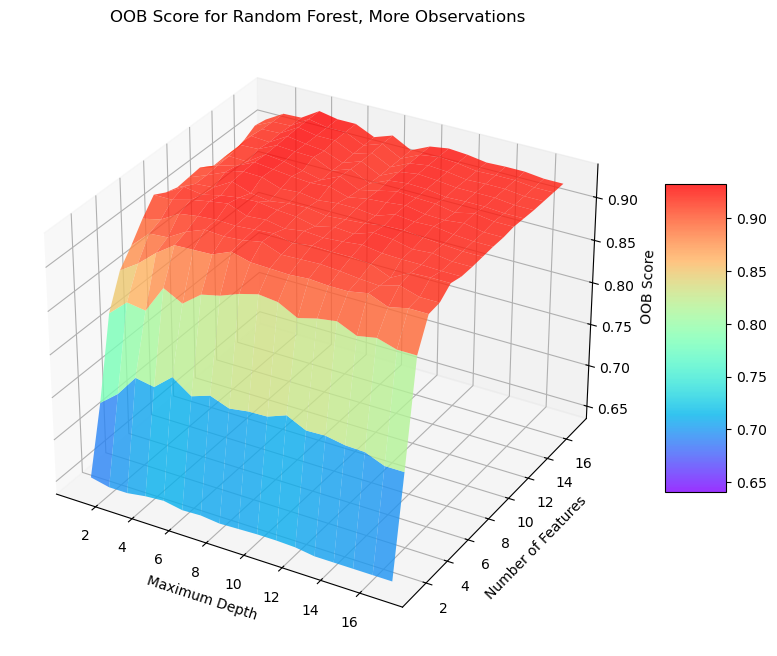

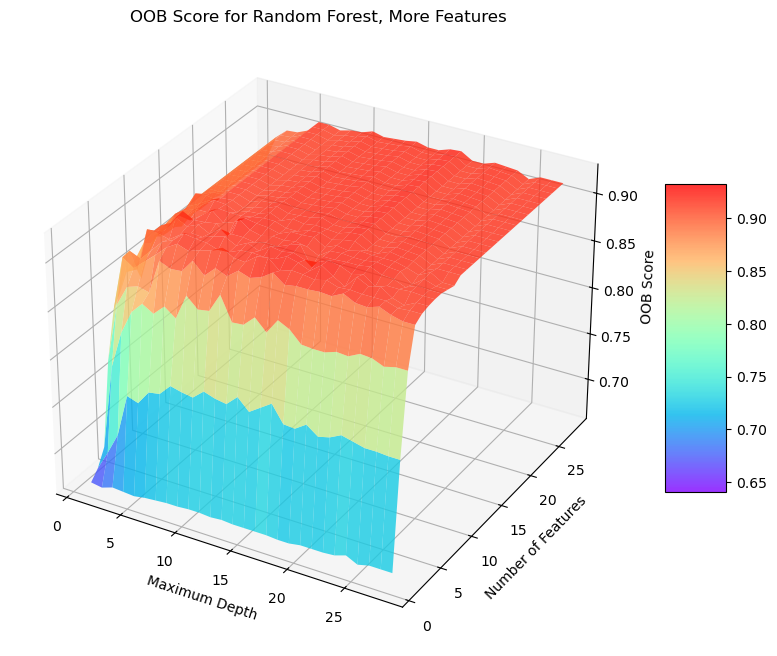

In [30]:
# extract oob data for plotting
num_feat_f = sorted(set([key[0] for key in rf_oob_f.keys()]))
max_depth_f = sorted(set([key[1] for key in rf_oob_f.keys()]))
oobs_f = np.array([rf_oob_f[(f, d)] for f in num_feat_f for d in max_depth_f]
                  ).reshape(len(num_feat_f), len(max_depth_f))

num_feat_o = sorted(set([key[0] for key in rf_oob_o.keys()]))
max_depth_o = sorted(set([key[1] for key in rf_oob_o.keys()]))
oobs_o = np.array([rf_oob_o[(f, d)] for f in num_feat_o for d in max_depth_o]
                  ).reshape(len(num_feat_o), len(max_depth_o))

num_feat_n = sorted(set([key[0] for key in rf_oob_n.keys()]))
max_depth_n = sorted(set([key[1] for key in rf_oob_n.keys()]))
oobs_n = np.array([rf_oob_n[(f, d)] for f in num_feat_n for d in max_depth_n]
                  ).reshape(len(num_feat_n), len(max_depth_n))

vmin = min(oobs_n.min(), oobs_o.min(), oobs_f.min())
print(vmin)
vmax = max(oobs_n.max(), oobs_o.max(), oobs_f.max())
print(vmax)

# GPT3.5 assisted with creating this code for plotting in 3D


# plot for base
# Reshape for surface plot
num_feats_mesh_n, max_depths_mesh_n = np.meshgrid(num_feat_n, max_depth_n)
oob_mesh_n = oobs_n.reshape(num_feats_mesh_n.shape)

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf_n = ax.plot_surface(max_depths_mesh_n, num_feats_mesh_n, oob_mesh_n, 
                         cmap='rainbow', alpha=0.8, vmin=vmin, vmax=vmax)
# Set labels and title
ax.set_xlabel('Maximum Depth')
ax.set_ylabel('Number of Features')
ax.set_zlabel('OOB Score')
# ax.set_xlim(1,5)
ax.set_title('OOB Score for Random Forest, Base')

# Add color bar
fig.colorbar(surf_n, ax=ax, shrink=0.5, aspect=5)
plt.show()



# plot for more observations
# Reshape for surface plot
num_feats_mesh_o, max_depths_mesh_o = np.meshgrid(num_feat_o, max_depth_o)
oob_mesh_o = oobs_o.reshape(num_feats_mesh_o.shape)

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf_o = ax.plot_surface(max_depths_mesh_o, num_feats_mesh_o, oob_mesh_o, 
                         cmap='rainbow', alpha=0.8, vmin=vmin, vmax=vmax)
# Set labels and title
ax.set_xlabel('Maximum Depth')
ax.set_ylabel('Number of Features')
ax.set_zlabel('OOB Score')
# ax.set_xlim(1,5)
ax.set_title('OOB Score for Random Forest, More Observations')

# Add color bar
fig.colorbar(surf_o, ax=ax, shrink=0.5, aspect=5)
plt.show()


# plot for more features
# Reshape for surface plot
num_feats_mesh_f, max_depths_mesh_f = np.meshgrid(num_features_f, max_depths_f)
oob_mesh_f = oobs_f.reshape(num_feats_mesh_f.shape)

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf_f = ax.plot_surface(max_depths_mesh_f, num_feats_mesh_f, oob_mesh_f, 
                         cmap='rainbow', alpha=0.8, vmin=vmin, vmax=vmax)
# Set labels and title
ax.set_xlabel('Maximum Depth')
ax.set_ylabel('Number of Features')
ax.set_zlabel('OOB Score')
# ax.set_xlim(1,5)
ax.set_title('OOB Score for Random Forest, More Features')

# Add color bar
fig.colorbar(surf_f, ax=ax, shrink=0.5, aspect=5)
plt.show()




## Train model for optimal values

In [31]:
rf_f = RandomForestClassifier(n_estimators=50, max_depth=rf_best_f[1], max_features=rf_best_f[0], random_state=10)
rf_o = RandomForestClassifier(n_estimators=50, max_depth=rf_best_o[1], max_features=rf_best_o[0], random_state=10)
rf_n = RandomForestClassifier(n_estimators=50, max_depth=rf_best_n[1], max_features=rf_best_n[0], random_state=10)

rf_f.fit(x_train_f_norm, y_train_f)
rf_o.fit(x_train_o_norm, y_train_o)
rf_n.fit(x_train_n_norm, y_train_n)

rf_y_pred_f = rf_f.predict(x_test_f_norm)
rf_y_pred_o = rf_o.predict(x_test_o_norm)
rf_y_pred_n = rf_n.predict(x_test_n_norm)


## Plotting test accuracy

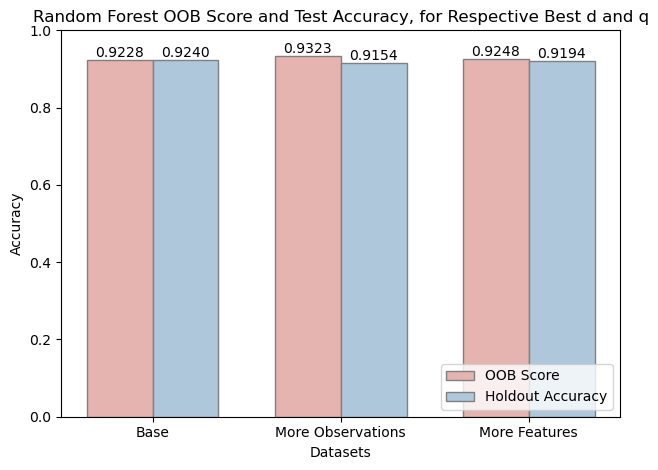

In [32]:
# plot accuracy bargraph
datasets = ['Base', 'More Observations', 'More Features']
accuracies = ['OOB Score', 'Holdout Accuracy']
scores = np.array([
    [rf_oob_n[rf_best_n], rf_acc_n[rf_best_n]],
    [rf_oob_o[rf_best_o], rf_acc_o[rf_best_o]],  
    [rf_oob_f[rf_best_f], rf_acc_f[rf_best_f]]
       
])

# Set width of bar
bar_width = 0.35

# Set positions of bars on x-axis
r1 = np.arange(3)
r2 = [x + bar_width for x in r1]

# Create grouped bar plot
bars1 = plt.bar(r1, scores[:, 0], color=cmap(1.0), width=bar_width, edgecolor='grey', label=accuracies[0])
bars2 = plt.bar(r2, scores[:, 1], color=cmap(0.25), width=bar_width, edgecolor='grey', label=accuracies[1])

# Add labels to bars
# note - GPT 3.5 was used to help with this function
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 '%.4f' % height,
                 ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

# Add labels, title, and legend
plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.title('Random Forest OOB Score and Test Accuracy, for Respective Best d and q')
plt.xticks([r + bar_width/2 for r in range(3)], datasets)
plt.ylim(0, 1)
plt.legend()

# Show plot
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()

0.6428571428571429
0.9400921658986175


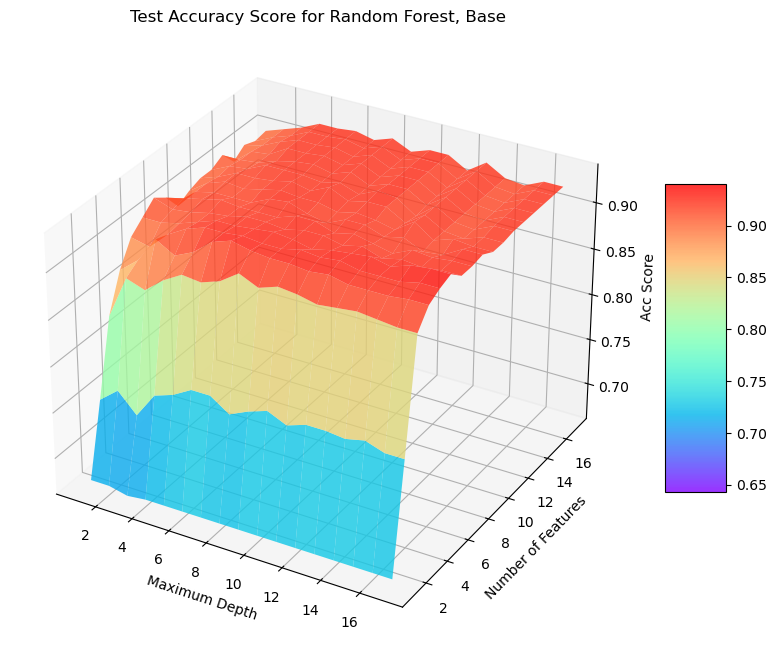

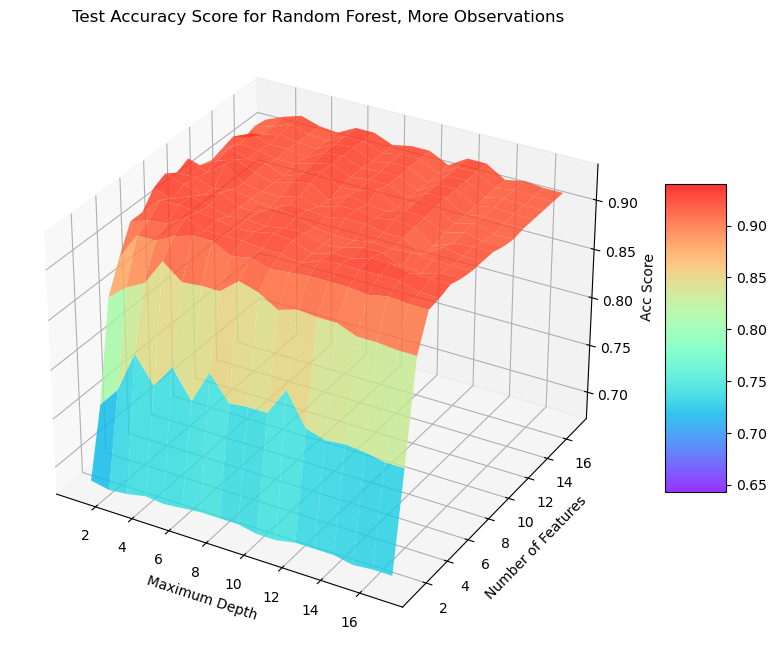

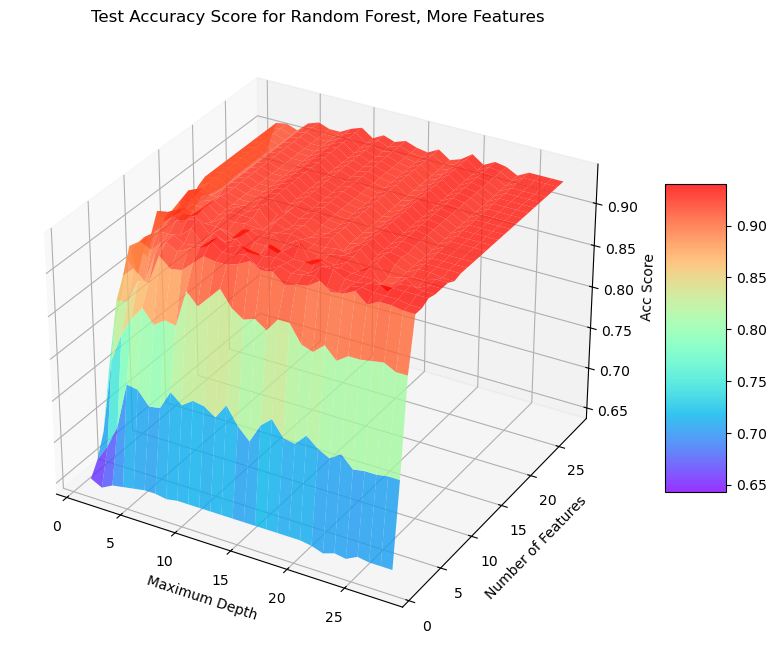

In [33]:
# extract accuracy data for plotting
num_feat_f = sorted(set([key[0] for key in rf_acc_f.keys()]))
max_depth_f = sorted(set([key[1] for key in rf_acc_f.keys()]))
accs_f = np.array([rf_acc_f[(f, d)] for f in num_feat_f for d in max_depth_f]
                  ).reshape(len(num_feat_f), len(max_depth_f))

num_feat_o = sorted(set([key[0] for key in rf_acc_o.keys()]))
max_depth_o = sorted(set([key[1] for key in rf_acc_o.keys()]))
accs_o = np.array([rf_acc_o[(f, d)] for f in num_feat_o for d in max_depth_o]
                  ).reshape(len(num_feat_o), len(max_depth_o))

num_feat_n = sorted(set([key[0] for key in rf_acc_n.keys()]))
max_depth_n = sorted(set([key[1] for key in rf_acc_n.keys()]))
accs_n = np.array([rf_acc_n[(f, d)] for f in num_feat_n for d in max_depth_n]
                  ).reshape(len(num_feat_n), len(max_depth_n))

vmin = min(accs_n.min(), accs_o.min(), accs_f.min())
print(vmin)
vmax = max(accs_n.max(), accs_o.max(), accs_f.max())
print(vmax)

# GPT3.5 assisted with creating this code for plotting in 3D

# plot for base
# Reshape for surface plot
num_feats_mesh_n, max_depths_mesh_n = np.meshgrid(num_feat_n, max_depth_n)
acc_mesh_n = accs_n.reshape(num_feats_mesh_n.shape)

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf_n = ax.plot_surface(max_depths_mesh_n, num_feats_mesh_n, acc_mesh_n, 
                         cmap='rainbow', alpha=0.8, vmin=vmin, vmax=vmax)
# Set labels and title
ax.set_xlabel('Maximum Depth')
ax.set_ylabel('Number of Features')
ax.set_zlabel('Acc Score')
# ax.set_xlim(1,5)
ax.set_title('Test Accuracy Score for Random Forest, Base')

# Add color bar
fig.colorbar(surf_n, ax=ax, shrink=0.5, aspect=5)
plt.show()



# plot for more observations
# Reshape for surface plot
num_feats_mesh_o, max_depths_mesh_o = np.meshgrid(num_feat_o, max_depth_o)
acc_mesh_o = accs_o.reshape(num_feats_mesh_o.shape)

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf_o = ax.plot_surface(max_depths_mesh_o, num_feats_mesh_o, acc_mesh_o, 
                         cmap='rainbow', alpha=0.8, vmin=vmin, vmax=vmax)
# Set labels and title
ax.set_xlabel('Maximum Depth')
ax.set_ylabel('Number of Features')
ax.set_zlabel('Acc Score')
# ax.set_xlim(1,5)
ax.set_title('Test Accuracy Score for Random Forest, More Observations')

# Add color bar
fig.colorbar(surf_o, ax=ax, shrink=0.5, aspect=5)
plt.show()


# plot for more features
# Reshape for surface plot
num_feats_mesh_f, max_depths_mesh_f = np.meshgrid(num_features_f, max_depths_f)
acc_mesh_f = accs_f.reshape(num_feats_mesh_f.shape)

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf_f = ax.plot_surface(max_depths_mesh_f, num_feats_mesh_f, acc_mesh_f, 
                         cmap='rainbow', alpha=0.8, vmin=vmin, vmax=vmax)
# Set labels and title
ax.set_xlabel('Maximum Depth')
ax.set_ylabel('Number of Features')
ax.set_zlabel('Acc Score')
# ax.set_xlim(1,5)
ax.set_title('Test Accuracy Score for Random Forest, More Features')

# Add color bar
fig.colorbar(surf_f, ax=ax, shrink=0.5, aspect=5)
plt.show()


## Confusion Matrices

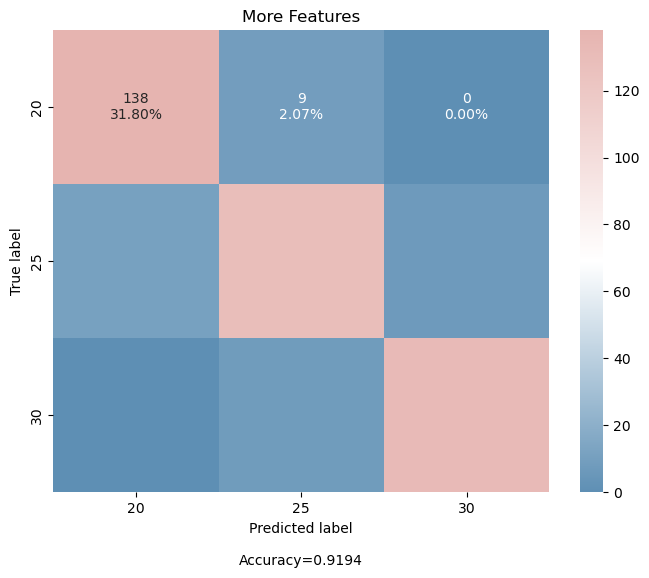

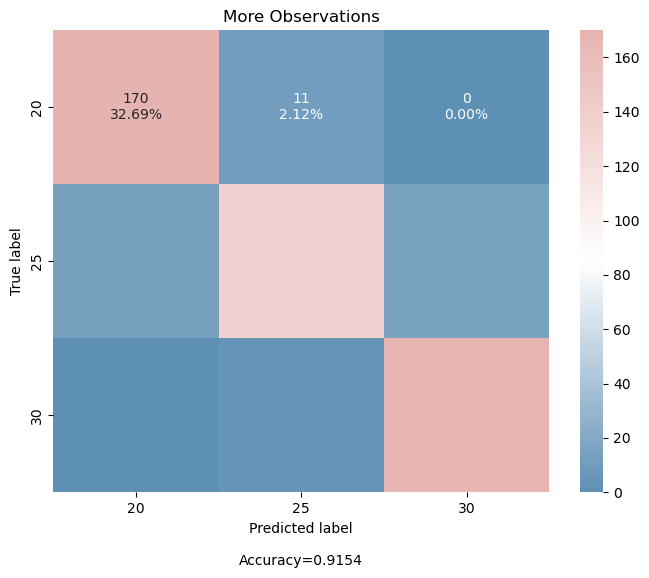

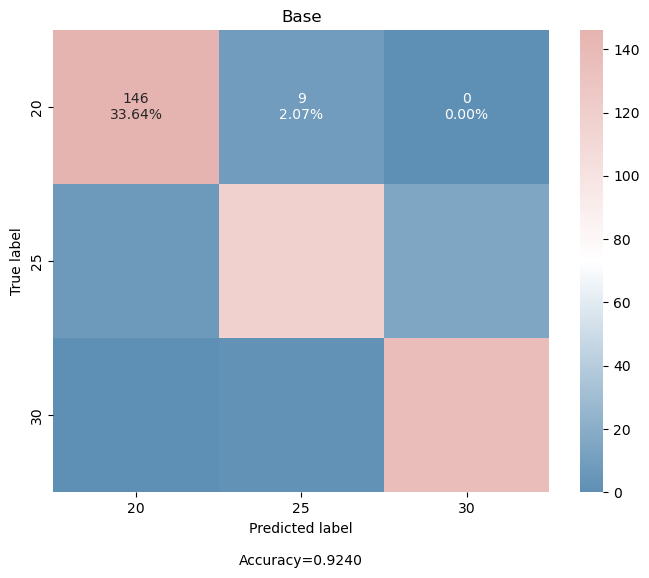

In [34]:
rf_confmat_f = confusion_matrix(y_test_f, rf_y_pred_f)
rf_confmat_o = confusion_matrix(y_test_o, rf_y_pred_o)
rf_confmat_n = confusion_matrix(y_test_n, rf_y_pred_n)

categories = [20, 25, 30]

f1 = make_confusion_matrix(rf_confmat_f, figsize=(8,6), categories=categories, title='More Features', cmap=cmap)
f2 = make_confusion_matrix(rf_confmat_o, figsize=(8,6), categories=categories, title='More Observations', cmap=cmap)
f3 = make_confusion_matrix(rf_confmat_n, figsize=(8,6), categories=categories, title='Base', cmap=cmap)

## ROC curves

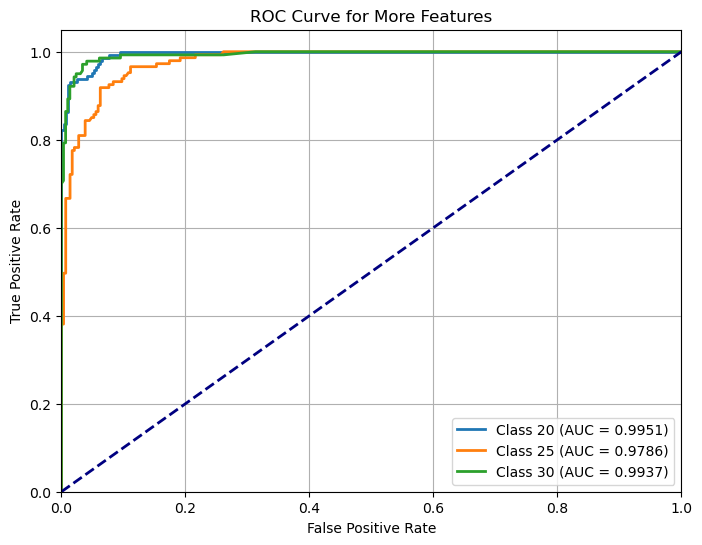

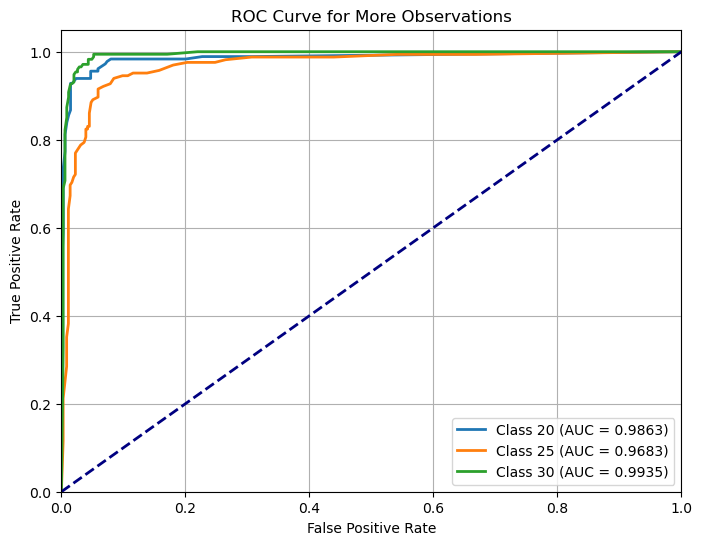

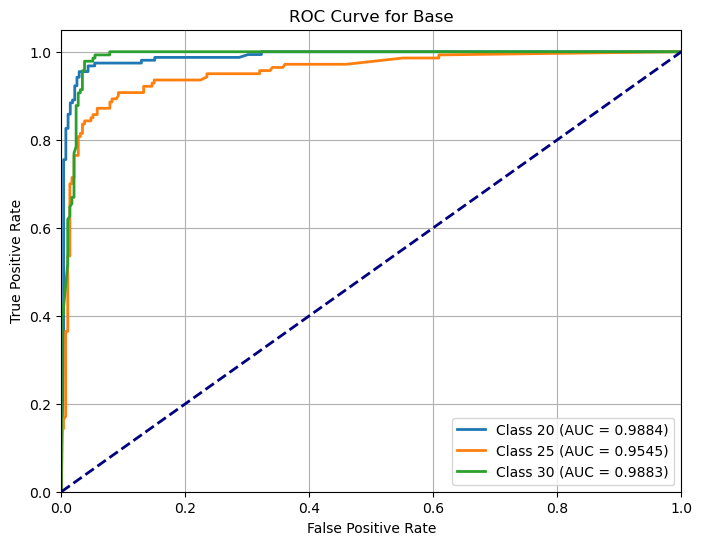

In [35]:

classes = [20, 25, 30]
# Predict probabilities for each class using the normalised test set
rf_y_score_f = rf_f.predict_proba(x_test_f_norm)
rf_y_score_o = rf_o.predict_proba(x_test_o_norm)
rf_y_score_n = rf_n.predict_proba(x_test_n_norm)


# Binarize the labels for ROC curve computation
rf_y_test_bin_f = label_binarize(y_test_f, classes=classes)
rf_n_classes_f = rf_y_test_bin_f.shape[1]
rf_y_test_bin_o = label_binarize(y_test_o, classes=classes)
rf_n_classes_o = rf_y_test_bin_o.shape[1]
rf_y_test_bin_n = label_binarize(y_test_n, classes=classes)
rf_n_classes_n = rf_y_test_bin_n.shape[1]

# Initialize variables for ROC curve and ROC AUC score
rf_fpr_f = dict()
rf_tpr_f = dict()
rf_roc_auc_f = dict()

rf_fpr_o = dict()
rf_tpr_o = dict()
rf_roc_auc_o = dict()

rf_fpr_n = dict()
rf_tpr_n = dict()
rf_roc_auc_n = dict()


# Compute ROC curve and ROC AUC score for each class in features
for i in range(rf_n_classes_f):
    rf_fpr_f[i], rf_tpr_f[i], _ = roc_curve(rf_y_test_bin_f[:, i], rf_y_score_f[:, i])
    rf_roc_auc_f[i] = auc(rf_fpr_f[i], rf_tpr_f[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i in range(rf_n_classes_f):
    plt.plot(rf_fpr_f[i], rf_tpr_f[i], lw=2, label=f'Class {classes[i]} (AUC = {rf_roc_auc_f[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for More Features')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



# Compute ROC curve and ROC AUC score for each class in o
for i in range(rf_n_classes_o):
    rf_fpr_o[i], rf_tpr_o[i], _ = roc_curve(rf_y_test_bin_o[:, i], rf_y_score_o[:, i])
    rf_roc_auc_o[i] = auc(rf_fpr_o[i], rf_tpr_o[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i in range(rf_n_classes_o):
    plt.plot(rf_fpr_o[i], rf_tpr_o[i], lw=2, label=f'Class {classes[i]} (AUC = {rf_roc_auc_o[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for More Observations')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



# Compute ROC curve and ROC AUC score for each class in base
for i in range(rf_n_classes_n):
    rf_fpr_n[i], rf_tpr_n[i], _ = roc_curve(rf_y_test_bin_n[:, i], rf_y_score_n[:, i])
    rf_roc_auc_n[i] = auc(rf_fpr_n[i], rf_tpr_n[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i in range(rf_n_classes_n):
    plt.plot(rf_fpr_n[i], rf_tpr_n[i], lw=2, label=f'Class {classes[i]} (AUC = {rf_roc_auc_n[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Base')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Section 4 - SVM

In [122]:
c_values = [10 ** x for x in range(-6, 6)]

# svm = SVC(kernel='linear')

svm_acc_f = {}
svm_acc_test_f = {}
svm_acc_o = {}
svm_acc_test_o = {}
svm_acc_n = {}
svm_acc_test_n = {}

In [123]:
print(c_values)

[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]


In [124]:

# train the model on each data subset, record accuracy scores train and test
for c in c_values:

    # Define the pipeline
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', random_state=101, C=c))  
    ])

    # Perform cross-validation
    svm_scores_f = cross_val_score(svm_pipeline, x_train_f, y_train_f, scoring='accuracy')
    svm_acc_f[c] = np.mean(svm_scores_f)
    svm_pipeline.fit(x_train_f, y_train_f)
    svm_y_pred_f = svm_pipeline.predict(x_test_f)
    svm_acc_test_f[c] = accuracy_score(y_test_f, svm_y_pred_f)


    svm_scores_o = cross_val_score(svm_pipeline, x_train_o, y_train_o, scoring='accuracy')
    svm_acc_o[c] = np.mean(svm_scores_o)
    svm_pipeline.fit(x_train_o, y_train_o)
    svm_y_pred_o = svm_pipeline.predict(x_test_o)
    svm_acc_test_o[c] = accuracy_score(y_test_o, svm_y_pred_o)


    svm_scores_n = cross_val_score(svm_pipeline, x_train_n, y_train_n, scoring='accuracy')
    svm_acc_n[c] = np.mean(svm_scores_n)
    svm_pipeline.fit(x_train_n, y_train_n)
    svm_y_pred_n = svm_pipeline.predict(x_test_n)
    svm_acc_test_n[c] = accuracy_score(y_test_n, svm_y_pred_n)






In [120]:
# print the results for my own information
# and record the best c value for each subset

print(f"Max train accuracy for 'More Features': {max(svm_acc_f.values())}")
svm_max_f = max(svm_acc_f, key=svm_acc_f.get)
print('C:', svm_max_f)
print(f"Test accuracy at C={svm_max_f}: {svm_acc_test_f[svm_max_f]}")
print(f"Max test accuracy for 'More Features': {max(svm_acc_test_f.values())} at C={max(svm_acc_test_f, key=svm_acc_test_f.get)}")
print()

print(f"Max train accuracy for 'More Observations': {max(svm_acc_o.values())}")
svm_max_o = max(svm_acc_o, key=svm_acc_o.get)
print('C:', svm_max_o)
print(f"Test accuracy at C={svm_max_o}: {svm_acc_test_o[svm_max_o]}")
print(f"Max test accuracy for 'More Observations': {max(svm_acc_test_o.values())} at C={max(svm_acc_test_o, key=svm_acc_test_o.get)}")
print()

print(f"Max train accuracy for 'Neither': {max(svm_acc_n.values())}")
svm_max_n = max(svm_acc_n, key=svm_acc_n.get)
print('C:', svm_max_n)
print(f"Test accuracy at C={svm_max_n}: {svm_acc_test_n[svm_max_n]}")
print(f"Max test accuracy for 'Neither': {max(svm_acc_test_n.values())} at C={max(svm_acc_test_n, key=svm_acc_test_n.get)}")
print()

Max train accuracy for 'More Features': 0.9218846022533288
C: 1
Test accuracy at C=1: 0.9470046082949308
Max test accuracy for 'More Features': 0.9470046082949308 at C=1

Max train accuracy for 'More Observations': 0.9471516511920551
C: 1
Test accuracy at C=1: 0.9346153846153846
Max test accuracy for 'More Observations': 0.9346153846153846 at C=1

Max train accuracy for 'Neither': 0.9505096815100229
C: 10
Test accuracy at C=10: 0.9308755760368663
Max test accuracy for 'Neither': 0.9423963133640553 at C=1



## Plot the accuracy against C

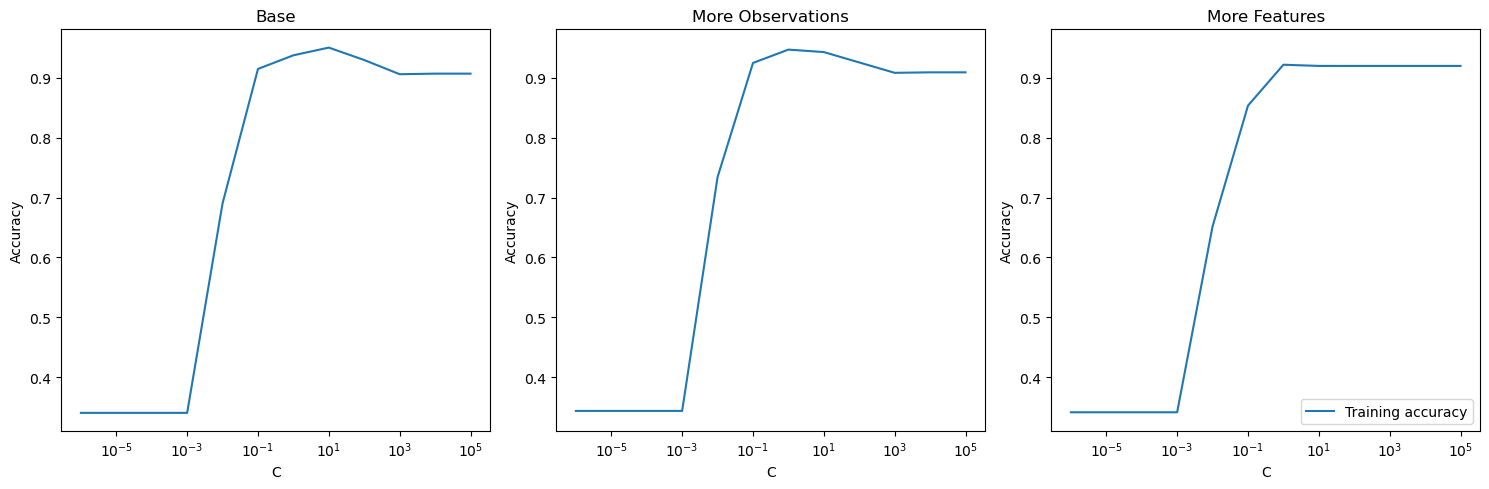

In [125]:
# Plot the accuracy scores for each k value
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axes[2].plot(c_values, svm_acc_f.values(), label='Training accuracy')
axes[2].set_title("More Features")
axes[2].set_xlabel("C")
axes[2].set_ylabel("Accuracy")
# axes[0].set_xticks(k_values)
axes[0].set_xscale('log', base=10)
axes[2].tick_params(axis='y', which='both', labelleft=True)  # Ensure y-axis labels are shown
axes[2].legend()


axes[1].plot(c_values, svm_acc_o.values())
axes[1].set_title("More Observations")
axes[1].set_xlabel("C")
axes[1].set_ylabel("Accuracy")
# axes[1].set_xticks(k_values)
axes[1].set_xscale('log', base=10)
axes[1].tick_params(axis='y', which='both', labelleft=True)  


axes[0].plot(c_values, svm_acc_n.values())
axes[0].set_title("Base")
axes[0].set_xlabel("C")
axes[0].set_ylabel("Accuracy")
# axes[2].set_xticks(k_values)
axes[2].set_xscale('log', base=10)
axes[0].tick_params(axis='y', which='both', labelleft=True)

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Plot the test accuracy

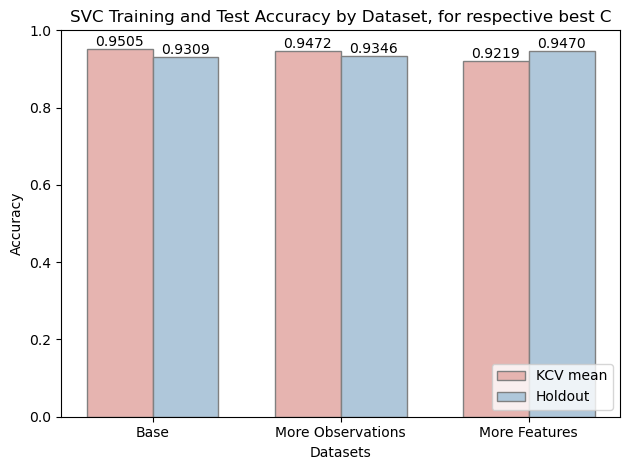

In [126]:
# plot accuracy bargraph
datasets = ['Base', 'More Observations', 'More Features']
accuracies = ['KCV mean', 'Holdout']
scores = np.array([
    [svm_acc_n[svm_max_n], svm_acc_test_n[svm_max_n]],
    [svm_acc_o[svm_max_o], svm_acc_test_o[svm_max_o]],  
    [svm_acc_f[svm_max_f], svm_acc_test_f[svm_max_f]]
       
])

# Set width of bar
bar_width = 0.35

# Set positions of bars on x-axis
r1 = np.arange(3)
r2 = [x + bar_width for x in r1]

# Create grouped bar plot
bars1 = plt.bar(r1, scores[:, 0], color=cmap(1.0), width=bar_width, edgecolor='grey', label=accuracies[0])
bars2 = plt.bar(r2, scores[:, 1], color=cmap(0.25), width=bar_width, edgecolor='grey', label=accuracies[1])

# Add labels to bars
# note - GPT 3.5 was used to help with this function
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 '%.4f' % height,
                 ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

# Add labels, title, and legend
plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.title('SVC Training and Test Accuracy by Dataset, for respective best C')
plt.xticks([r + bar_width/2 for r in range(3)], datasets)
plt.ylim(0, 1)
plt.legend()

# Show plot
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()

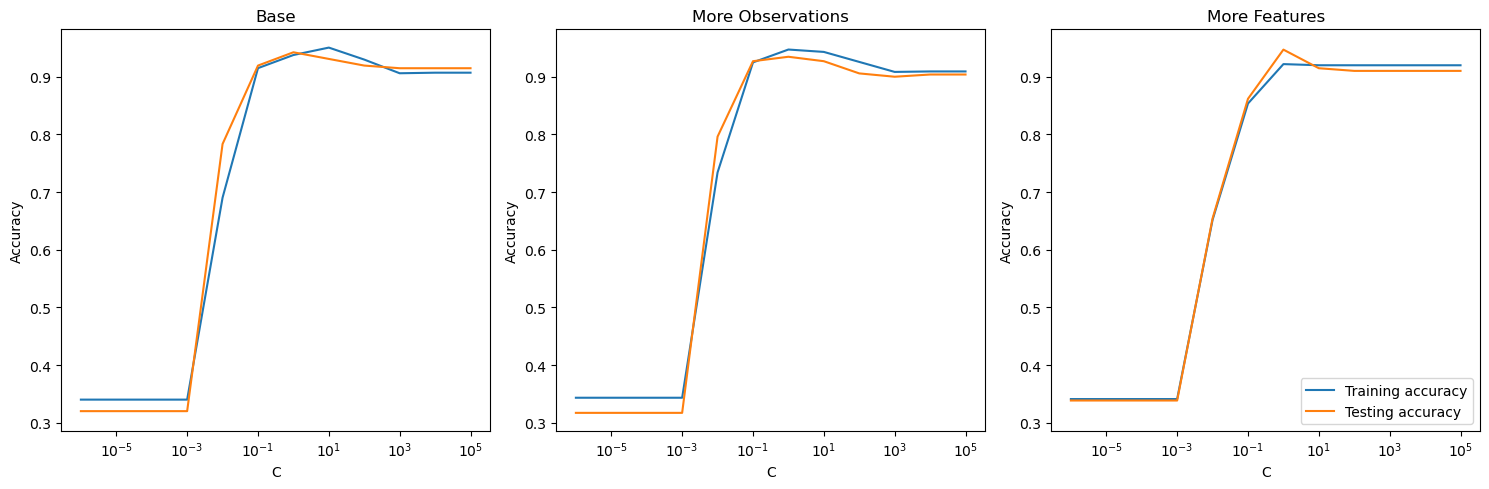

In [127]:
# Plot the accuracy scores for each c value
# WITH TEST ACCURACY
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)


axes[2].plot(c_values, svm_acc_f.values(), label='Training accuracy')
axes[2].plot(c_values, svm_acc_test_f.values(), label='Testing accuracy')
axes[2].set_title("More Features")
axes[2].set_xlabel("C")
axes[2].set_ylabel("Accuracy")
axes[2].set_xscale('log', base=10)
axes[2].tick_params(axis='y', which='both', labelleft=True)  # Ensure y-axis labels are shown
axes[2].legend()


axes[1].plot(c_values, svm_acc_o.values(), label='Training accuracy')
axes[1].plot(c_values, svm_acc_test_o.values(), label='Testing accuracy')
axes[1].set_title("More Observations")
axes[1].set_xlabel("C")
axes[1].set_ylabel("Accuracy")
axes[1].set_xscale('log', base=10)
axes[1].tick_params(axis='y', which='both', labelleft=True)  


axes[0].plot(c_values, svm_acc_n.values(), label='Training accuracy')
axes[0].plot(c_values, svm_acc_test_n.values(), label='Testing accuracy')
axes[0].set_title("Base")
axes[0].set_xlabel("C")
axes[0].set_ylabel("Accuracy")
axes[0].set_xscale('log', base=10)
axes[0].tick_params(axis='y', which='both', labelleft=True)


plt.tight_layout()
plt.legend(loc='lower right')
plt.show()

## Train model for best C

In [43]:
# This is needed for the confusion matrix

# define each pipeline
svm_pipeline_f = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm', SVC(kernel='linear', C=svm_max_f, random_state=101, probability=True))
])

svm_pipeline_o = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm', SVC(kernel='linear', C=svm_max_o, random_state=101, probability=True)) 
])

svm_pipeline_n = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm', SVC(kernel='linear', C=svm_max_n, random_state=101, probability=True)) 
])

# fit each pipeline to the training data
svm_pipeline_f.fit(x_train_f, y_train_f)
svm_pipeline_o.fit(x_train_o, y_train_o)
svm_pipeline_n.fit(x_train_n, y_train_n)


# get predicted y values
svm_y_pred_f = svm_pipeline_f.predict(x_test_f)
svm_y_pred_o = svm_pipeline_o.predict(x_test_o)
svm_y_pred_n = svm_pipeline_n.predict(x_test_n)

## Confusion matrices

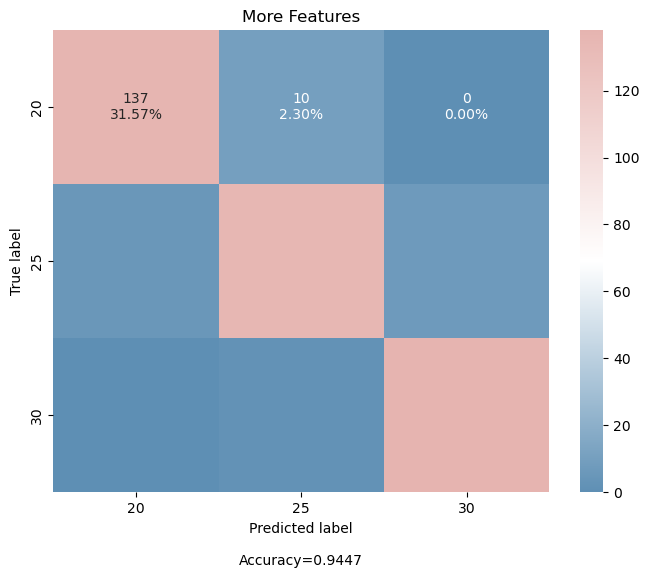

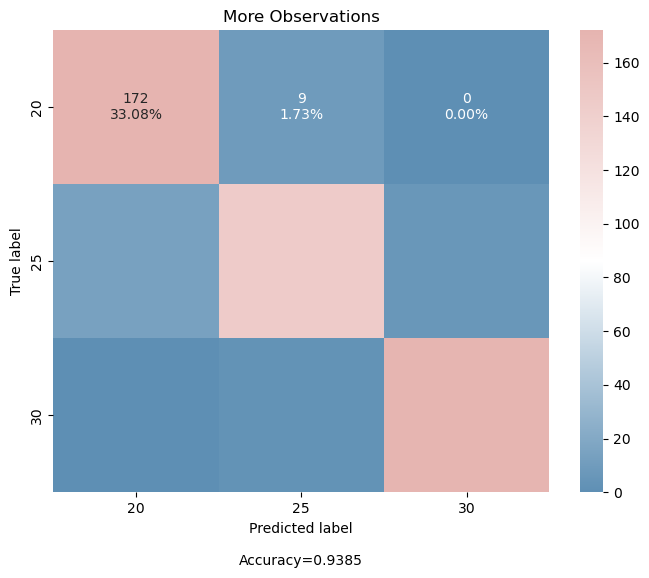

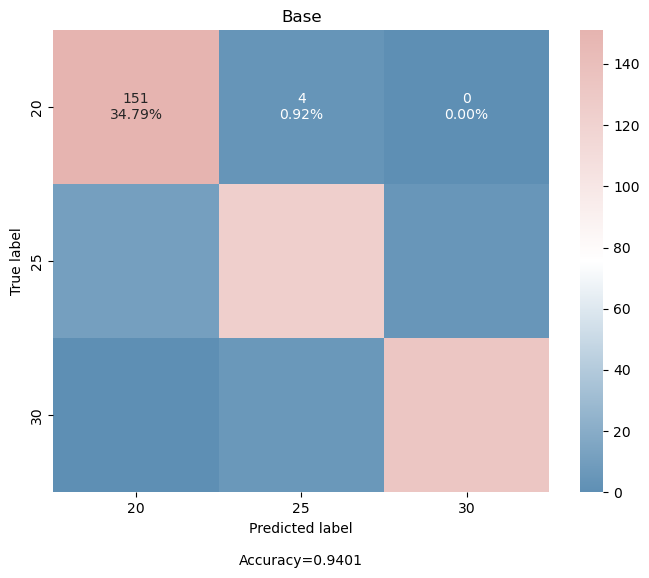

In [44]:
svm_confmat_f = confusion_matrix(y_test_f, svm_y_pred_f)
svm_confmat_o = confusion_matrix(y_test_o, svm_y_pred_o)
svm_confmat_n = confusion_matrix(y_test_n, svm_y_pred_n)

categories = [20, 25, 30]

f1 = make_confusion_matrix(svm_confmat_f, figsize=(8,6), categories=categories, title='More Features', cmap=cmap)
f2 = make_confusion_matrix(svm_confmat_o, figsize=(8,6), categories=categories, title='More Observations', cmap=cmap)
f3 = make_confusion_matrix(svm_confmat_n, figsize=(8,6), categories=categories, title='Base', cmap=cmap)


## ROC curves

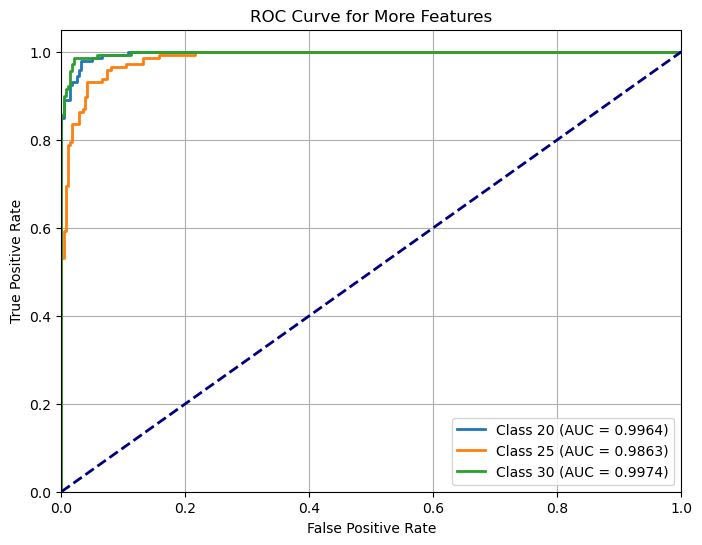

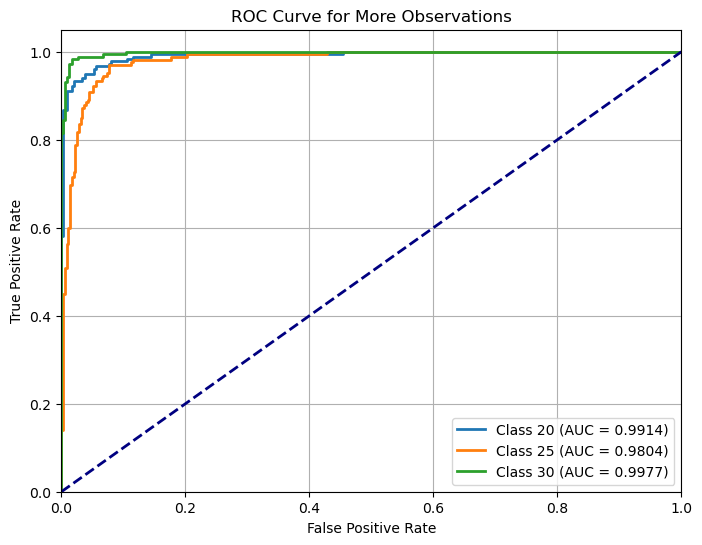

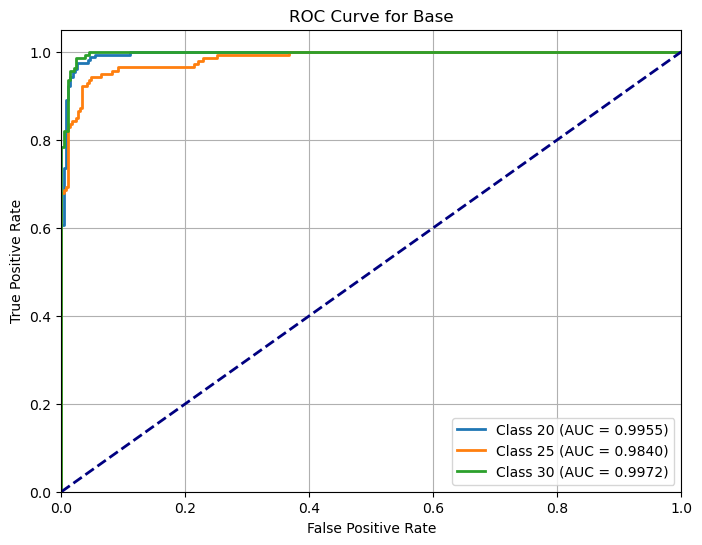

In [45]:
# GPT3.5 assited with modifying this code from the sklearn documentation 
# to apply to this situation in particular

classes = [20, 25, 30]
# Predict probabilities for each class using the test set
svm_y_score_f = svm_pipeline_f.predict_proba(x_test_f)
svm_y_score_o = svm_pipeline_o.predict_proba(x_test_o)
svm_y_score_n = svm_pipeline_n.predict_proba(x_test_n)


# Binarize the labels for ROC curve computation
svm_y_test_bin_f = label_binarize(y_test_f, classes=classes)
svm_y_test_bin_o = label_binarize(y_test_o, classes=classes)
svm_y_test_bin_n = label_binarize(y_test_n, classes=classes)

# Initialize variables for ROC curve and ROC AUC score
svm_fpr_f = dict()
svm_tpr_f = dict()
svm_roc_auc_f = dict()

svm_fpr_o = dict()
svm_tpr_o = dict()
svm_roc_auc_o = dict()

svm_fpr_n = dict()
svm_tpr_n = dict()
svm_roc_auc_n = dict()


# Compute ROC curve and ROC AUC score for each class in f
for i in range(len(svm_pipeline_f.classes_)):
    svm_fpr_f[i], svm_tpr_f[i], _ = roc_curve(svm_y_test_bin_f[:, i], svm_y_score_f[:, i])
    svm_roc_auc_f[i] = auc(svm_fpr_f[i], svm_tpr_f[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i in range(len(classes)):
    plt.plot(svm_fpr_f[i], svm_tpr_f[i], lw=2, label=f'Class {classes[i]} (AUC = {svm_roc_auc_f[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for More Features')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



# Compute ROC curve and ROC AUC score for each class in o
for i in range(len(svm_pipeline_o.classes_)):
    svm_fpr_o[i], svm_tpr_o[i], _ = roc_curve(svm_y_test_bin_o[:, i], svm_y_score_o[:, i])
    svm_roc_auc_o[i] = auc(svm_fpr_o[i], svm_tpr_o[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i in range(len(classes)):
    plt.plot(svm_fpr_o[i], svm_tpr_o[i], lw=2, label=f'Class {classes[i]} (AUC = {svm_roc_auc_o[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for More Observations')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



# Compute ROC curve and ROC AUC score for each class in base
for i in range(len(svm_pipeline_n.classes_)):
    svm_fpr_n[i], svm_tpr_n[i], _ = roc_curve(svm_y_test_bin_n[:, i], svm_y_score_n[:, i])
    svm_roc_auc_n[i] = auc(svm_fpr_n[i], svm_tpr_n[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i in range(len(classes)):
    plt.plot(svm_fpr_n[i], svm_tpr_n[i], lw=2, label=f'Class {classes[i]} (AUC = {svm_roc_auc_n[i]:0.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Base')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# PCA lol pls ignore

In [95]:





features = [col for col in df.columns]

imputer = sklearn.impute.SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


x = df.loc[:, features].values

y = df.loc[:,['Temperature']].values


x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['pc1', 'pc2'])

finalDf = pd.concat([principalDf, df[['Temperature']]],axis=1)



In [96]:
x

array([[-1.02990984, -1.41688253, -1.22263148, ...,  1.45882482,
        -0.98190443, -0.8494182 ],
       [-1.02990984, -1.41688253, -1.22263148, ..., -0.94991616,
        -0.70170436, -0.59613237],
       [-1.02990984, -1.41688253, -1.22263148, ...,  1.19842039,
         0.52417095,  0.92358263],
       ...,
       [ 0.97095878,  1.41934026,  1.23113674, ..., -0.75461284,
        -0.94687942,  0.82860044],
       [ 0.97095878,  1.41934026,  1.23113674, ..., -0.36400619,
         0.94447106, -1.1660255 ],
       [ 0.97095878,  1.41934026,  1.23113674, ...,  0.09170156,
         0.20894587, -0.67528419]])

In [97]:
finalDf

pc1       pc2  Temperature
0    -6.439423  2.910849         20.0
1    -1.805529 -2.501247         20.0
2    -5.150077  0.937670         20.0
3    -0.875815 -1.845490         20.0
4    -4.873369 -1.677149         20.0
...        ...       ...          ...
1726  4.294608 -1.644078         30.0
1727  1.114944 -0.131045         30.0
1728  4.891392 -1.737278         30.0
1729  2.054724  1.355176         30.0
1730  2.897777 -1.092180         30.0

[1731 rows x 3 columns]

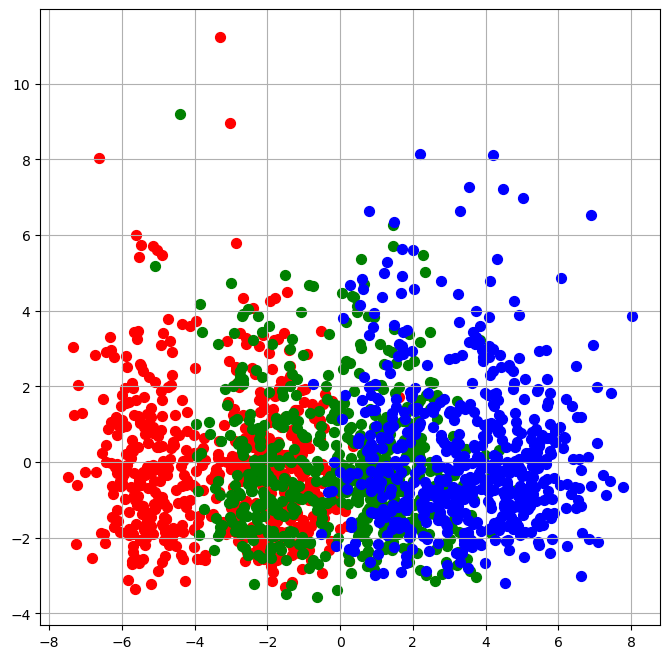

In [99]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

targets = [20, 25, 30]
colors = ['r', 'g', 'b']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Temperature'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1'],
               finalDf.loc[indicesToKeep, 'pc2'],
               c=color, s=50)
    
ax.grid()

In [ ]:
'''
KNN
highest train: more obs
highest test: base

RF
highest train: more obs
highest test: base

SVC
highest train: more obs
highest test: features

.89.947

'''

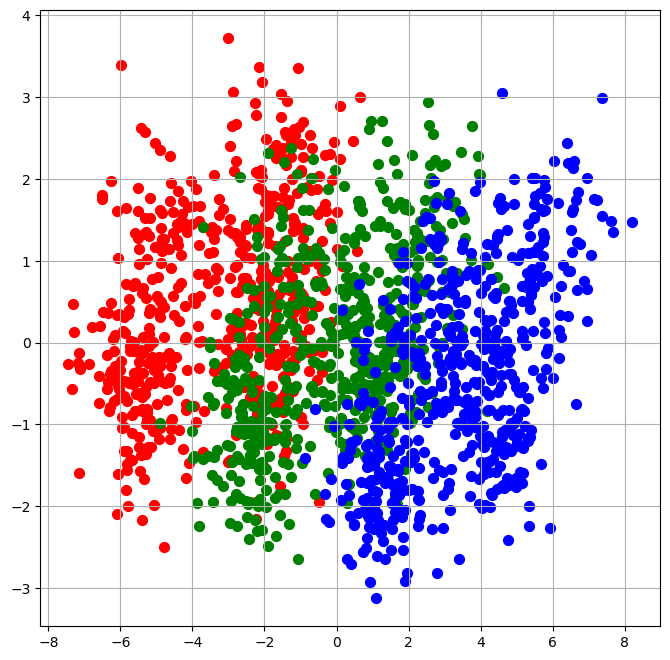

In [136]:


# df = df.drop(columns = ['Asymmetry_l2', 'Asymmetry_l3p', 'Asymmetry_l3d', 
#                                          'Asymmetry_lpd', 'Asymmetry_l3', 'Asymmetry_w1', 
#                                          'Asymmetry_w2', 'Asymmetry_w3', 'Asymmetry_wing_area', 
#                                          'Asymmetry_wing_shape', 'Asymmetry_wing_vein'])

features = [col for col in df.columns]

imputer = sklearn.impute.SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


x = df.loc[:, features].values

y = df.loc[:,['Temperature']].values


x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['pc1', 'pc2', 'pc3'])

finalDf = pd.concat([principalDf, df[['Temperature']]],axis=1)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

targets = [20, 25, 30]
colors = ['r', 'g', 'b']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Temperature'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1'],
               finalDf.loc[indicesToKeep, 'pc2'],
               c=color, s=50)
    
ax.grid()